In [1]:
### import the packages needed 
import re
import numpy as np
import pandas as pd
import geopandas as gpd
import numpy as np
import itertools

from scipy import linalg
import sklearn
from sklearn.datasets import make_blobs, make_circles, make_moons

import plotly_express as px

import matplotlib as mpl
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 


import altair as alt
np.random.seed(31)
%matplotlib inline

In [2]:
### set the default figure size for marplotlib plot to be 10 inches in width and 6 inches in height
plt.rcParams['figure.figsize'] = (10,6)

In [3]:
# load the data CSV file 

df=pd.read_csv('/rds/general/user/hg1222/home/Group5/matching/matched_data.csv', header=0, index_col=0)

In [4]:
df.shape

(14625, 30)

In [5]:
print(df)

         X.1      X      eid  Age_recr.0.0  Sex.0.0  BMI.0.0  Mood_swings.0.0  \
1          1      1  1003113            59        1  30.4255                0   
2          2      2  1010279            67        1  23.9732                0   
3          3      3  1028033            56        0  28.7553                0   
4          4      4  1029141            67        0  32.1263                0   
5          5      5  1029272            69        1  25.7484                0   
...      ...    ...      ...           ...      ...      ...              ...   
49295  49295  49295  6018481            65        1  32.4567                0   
49303  49303  49303  6019168            65        1  20.9637                1   
49310  49310  49310  6019940            69        1  22.3899                0   
49316  49316  49316  6020818            69        0  21.9116                0   
49336  49336  49336  6023021            65        1  28.7842                1   

       Smoking_status.0.0  

In [6]:
### drop out the columns that are not needed 
df.drop(['cancer'], axis =1, inplace=True)
df.drop(['X.1', 'X', 'eid'], axis =1, inplace=True)
df.drop(['case_status', 'case_lymph', 'case_leuk'], axis =1, inplace=True)
df.drop(['C_reactive_protein.0.0', 'Traff_int_major_rd.0.0', 'housing_score'], axis =1, inplace=True)
df.drop(['Age_recr.0.0', 'Sex.0.0', 'BMI.0.0'], axis =1, inplace=True)
df.drop(['Mood_swings.0.0', 'Smoking_status.0.0', 'Alc_drinker_status.0.0'], axis =1, inplace=True)

In [7]:
df.shape

(14625, 14)

In [8]:
print(df)

       Lymphocyte_count.0.0  Monocyte_count.0.0  Reti_count.0.0  \
1                      2.60                0.50           0.074   
2                      7.20                0.40           0.039   
3                      1.90                0.40           0.067   
4                      3.60                0.60           0.070   
5                      7.00                0.55           0.040   
...                     ...                 ...             ...   
49295                  1.70                0.49           0.079   
49303                  2.50                0.70           0.049   
49310                  1.70                0.50           0.045   
49316                  3.46                0.20           0.038   
49336                  1.70                0.30           0.049   

       WBC_count.0.0  RBC_count.0.0  Hgb_conc.0.0  Haematocrit_perc.0.0  \
1               8.10          4.920         14.20                 41.50   
2              14.00          4.700         1

In [9]:
df.drop(['health_score'], axis =1, inplace=True)

In [10]:
### standardize the data,  scalling the features to have zero mean and unit variance

from sklearn.preprocessing import StandardScaler 

# Create a StandardScaler object 
scaler = StandardScaler()

# Fit the scaler to the data 
scaler.fit(df)

# Transform the data 
df_standardized = scaler.transform(df)

In [11]:
## df_standardized after scaling is an array, not a pandas DataFrame
## convert back to a dataframe 

df_standardized = pd.DataFrame(df_standardized, columns = df.columns)

In [12]:
df_standardized.shape

(14625, 13)

<AxesSubplot: >

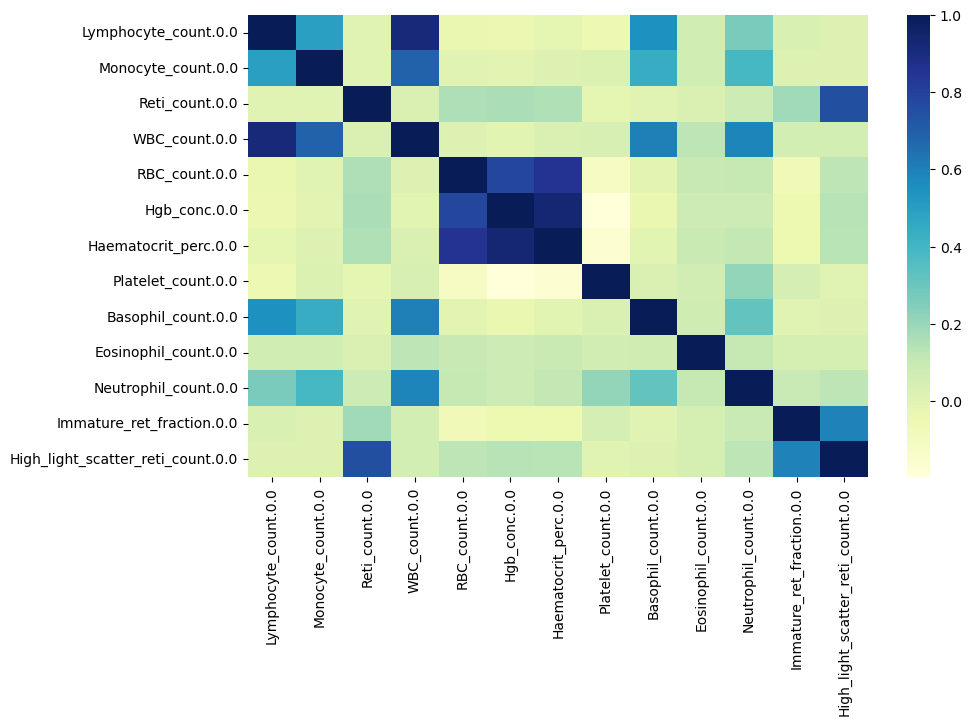

In [13]:
### check the correlation matrix to see if I need to use PCA or not 

import seaborn as sns

# Generate correlation matrix
corr_matrix = df_standardized.corr()

# Plot heatmap of correlation matrix
sns.heatmap(corr_matrix, cmap="YlGnBu")


Explained variance of each component: [2.47789347e-01 2.21281256e-01 1.51864666e-01 8.74689477e-02
 7.19338696e-02 6.05752968e-02 4.88074315e-02 4.09555355e-02
 3.84671083e-02 1.71607868e-02 9.30860076e-03 4.38413984e-03
 3.01437020e-06]


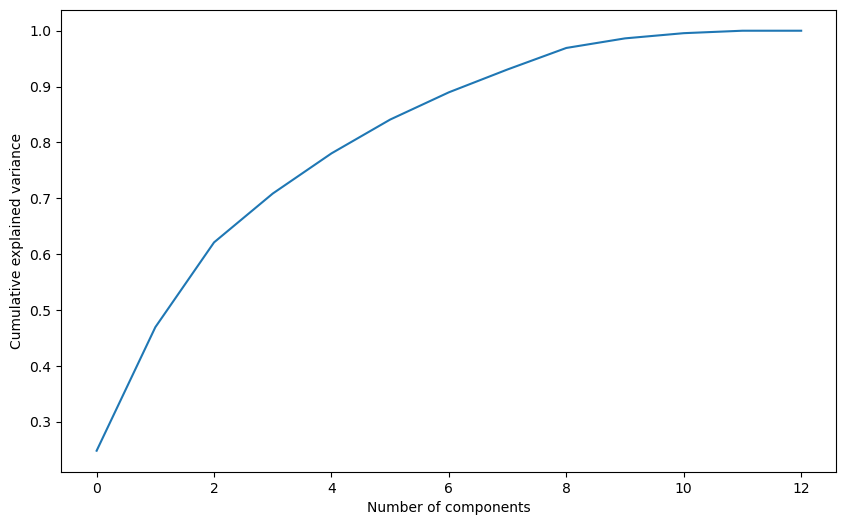

In [14]:
### there are multicollinearity, maybe do a PCA?

from sklearn.decomposition import PCA

# Create a PCA object with number of components equal to number of features
pca = PCA(n_components=df.shape[1])

# Fit PCA on standardized data
pca.fit(df_standardized)

# Get explained variance ratio of each component
explained_variance = pca.explained_variance_ratio_

# Print explained variance of each component
print("Explained variance of each component:", explained_variance)

# Plot cumulative explained variance
import matplotlib.pyplot as plt
plt.plot(np.cumsum(explained_variance))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.show()


Each element of the array represents the proportion of the total variance in the original data that is explained by the corresponding principal component. For example, the first element of the array (1.48119761e-01) indicates that the first principal component explains about 14.8% of the total variance in the data, while the second element (1.37550497e-01) indicates that the second principal component explains about 13.8% of the total variance in the data, and so on.

In [15]:
# Calculate the explained variance ratios
variance_ratios = pca.explained_variance_ratio_

# Calculate the percent variance explained
percent_variance_exp = np.round(variance_ratios * 100, 2)

print("Percent variance explained:", percent_variance_exp)

Percent variance explained: [24.78 22.13 15.19  8.75  7.19  6.06  4.88  4.1   3.85  1.72  0.93  0.44
  0.  ]


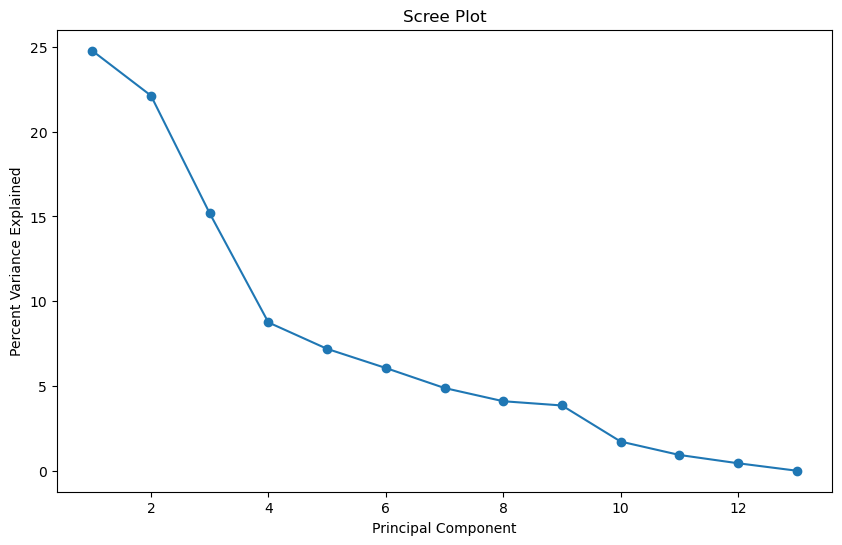

In [16]:
import matplotlib.pyplot as plt

# Create a scree plot
plt.plot(range(1, 14), percent_variance_exp, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Percent Variance Explained')
plt.title('Scree Plot')
plt.show()


In [17]:
print(df_standardized)

       Lymphocyte_count.0.0  Monocyte_count.0.0  Reti_count.0.0  \
0                  0.101115            0.000724        0.380855   
1                  1.352502           -0.097026       -0.584809   
2                 -0.089314           -0.097026        0.187722   
3                  0.373155            0.098473        0.270493   
4                  1.298094            0.049599       -0.557218   
...                     ...                 ...             ...   
14620             -0.143722           -0.009051        0.518807   
14621              0.073910            0.196223       -0.308905   
14622             -0.143722            0.000724       -0.419266   
14623              0.335070           -0.292524       -0.612399   
14624             -0.143722           -0.194775       -0.308905   

       WBC_count.0.0  RBC_count.0.0  Hgb_conc.0.0  Haematocrit_perc.0.0  \
0           0.195336       0.901972     -0.088446              0.017708   
1           1.362884       0.381643     -0.58

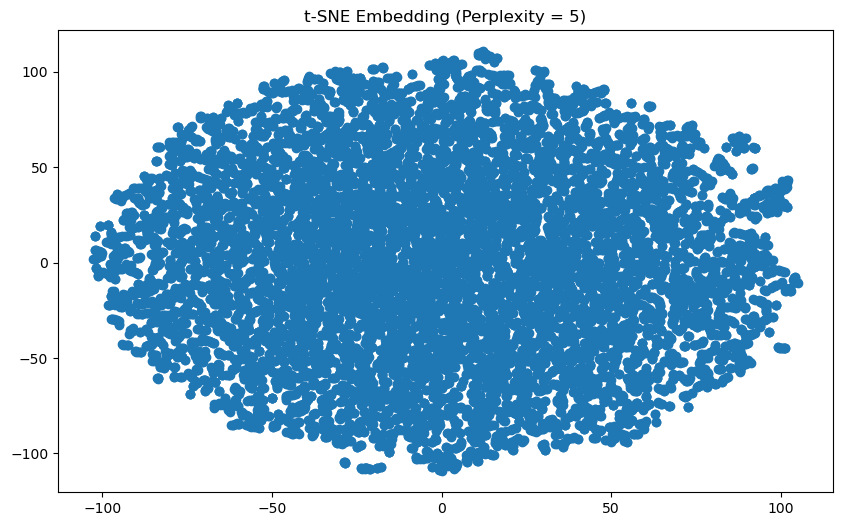

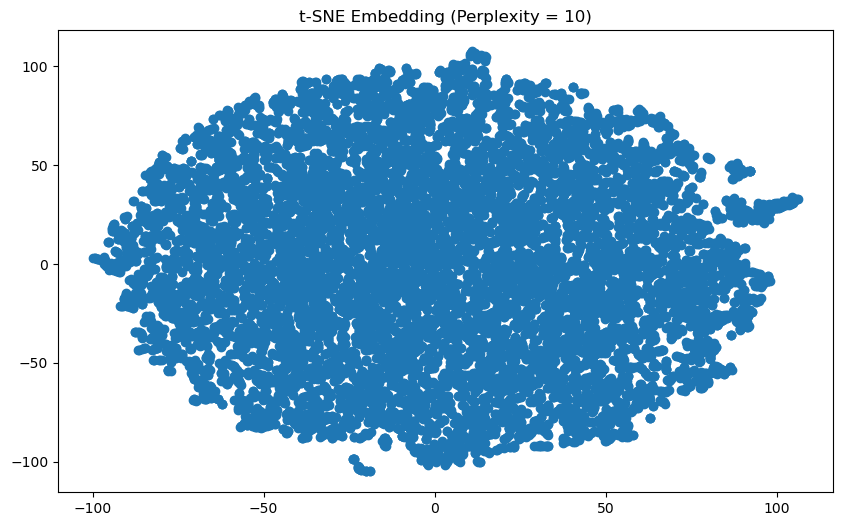

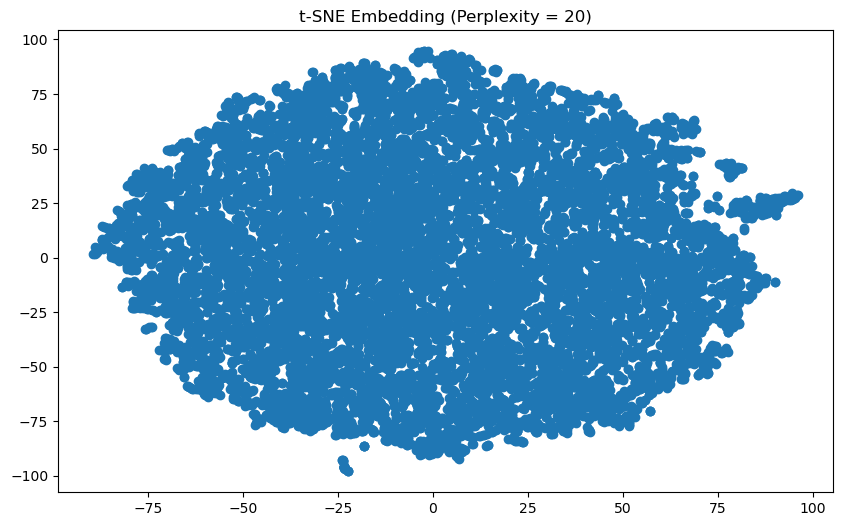

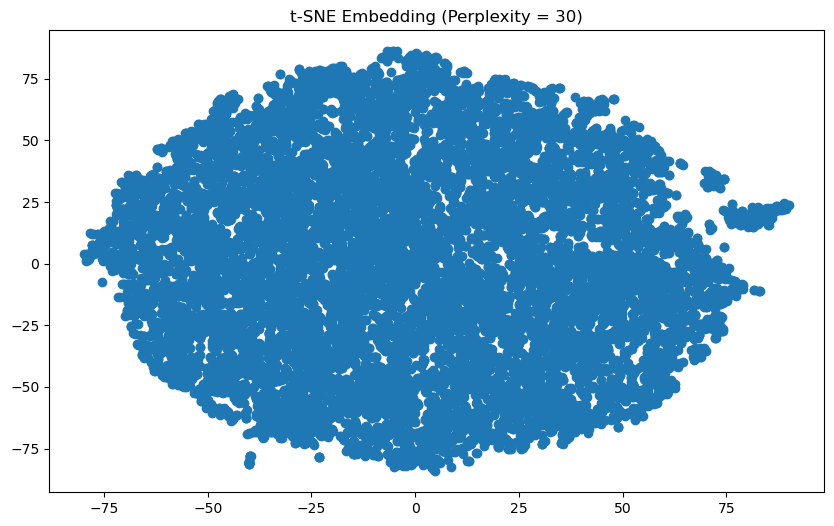

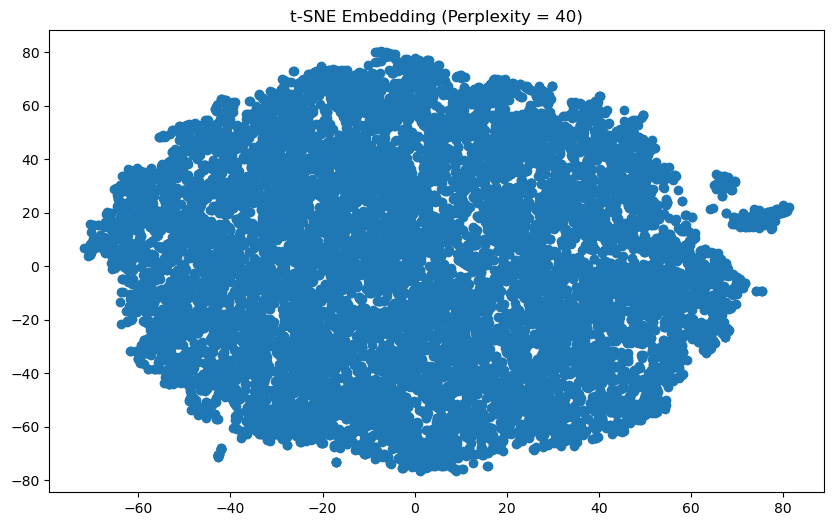

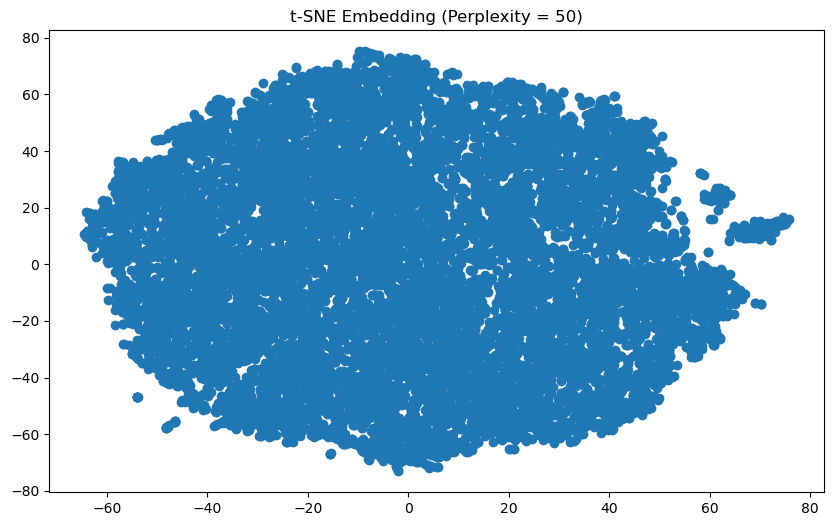

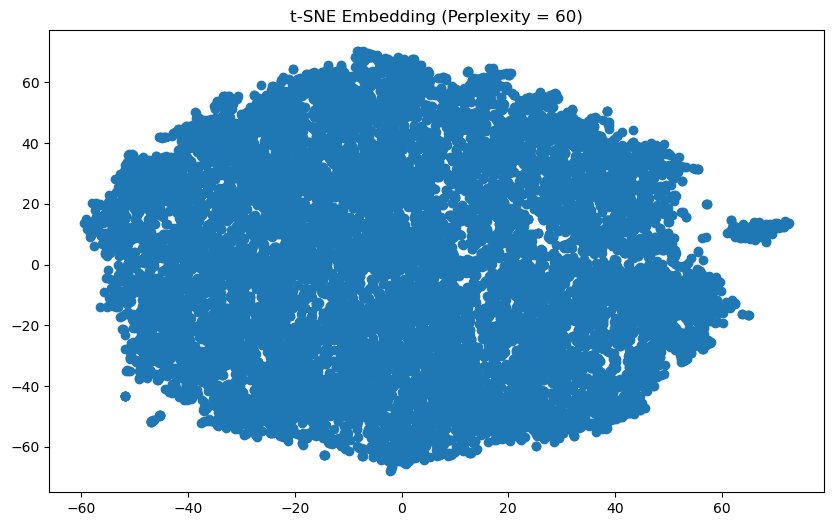

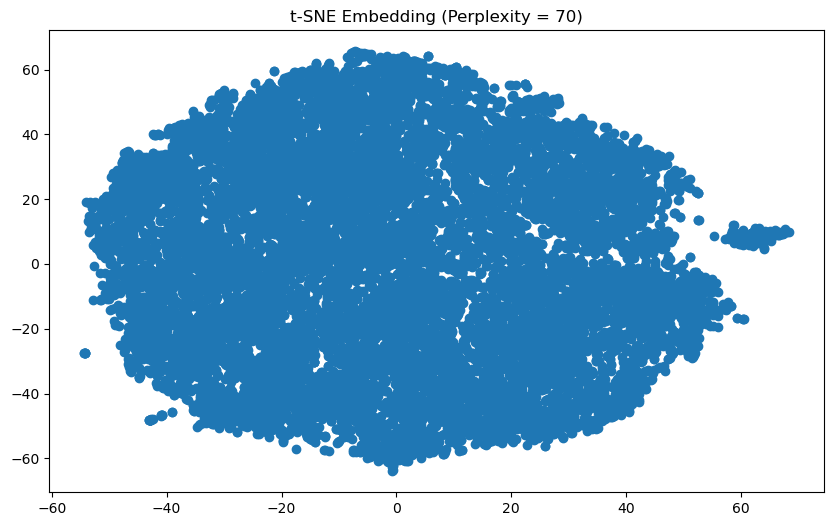

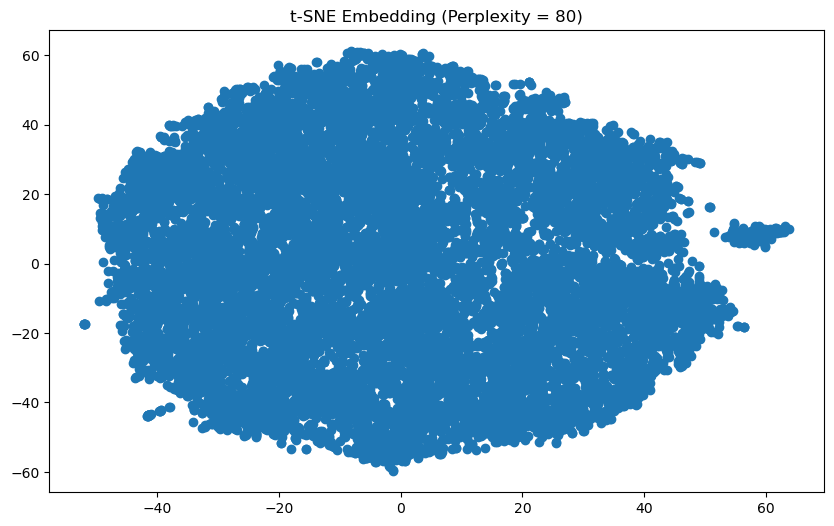

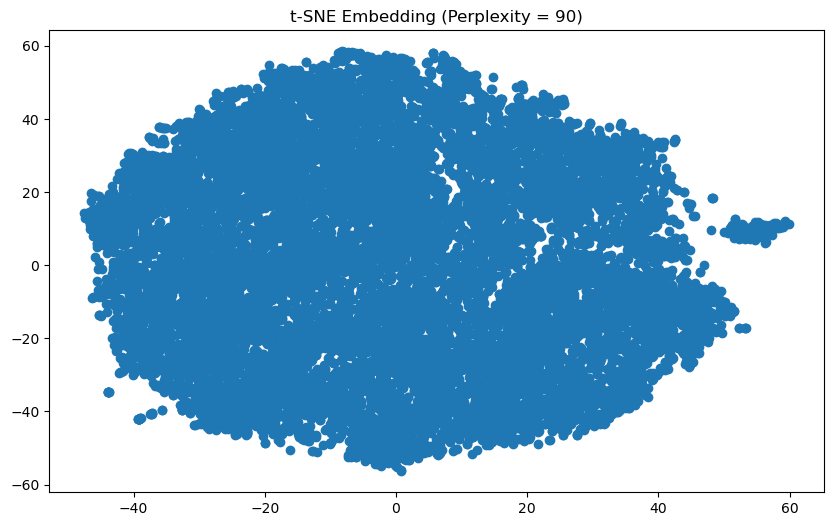

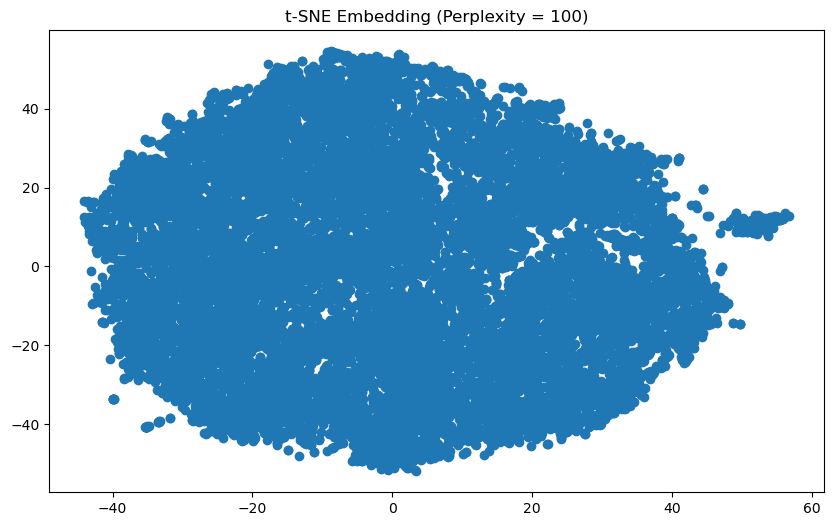

In [20]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import numpy as np

# df_standardized is the high-dimensional data

# Define a grid of perplexicty values to test, 5, 20, 20, 30, 40, 50 
perplexities = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
 

# fit t-SNE model for each perplexity value using the training data
for perplexity in perplexities: 
    tsne = TSNE(n_components=2, perplexity=perplexity)
    X_tsne = tsne.fit_transform(df_standardized)

# Plot the results for each perplexity value
    plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
    plt.title(f"t-SNE Embedding (Perplexity = {perplexity})")
    plt.show()

/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto

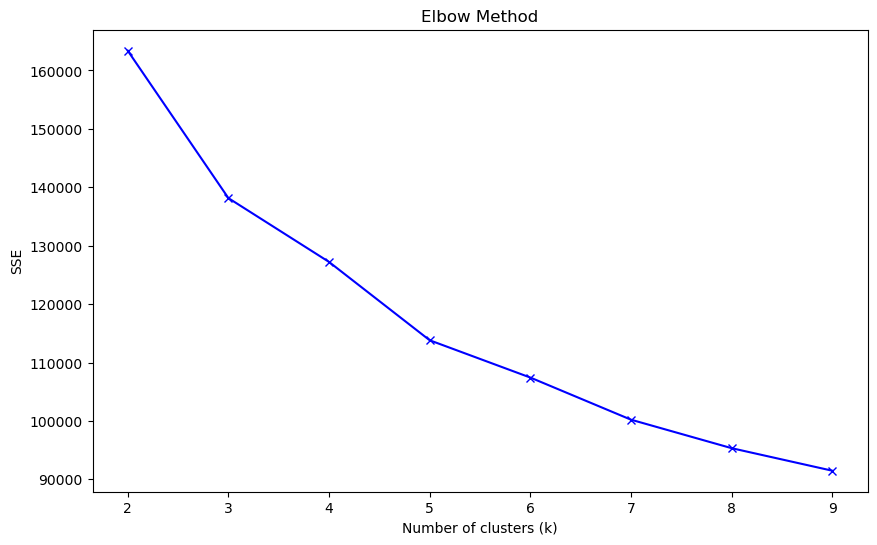

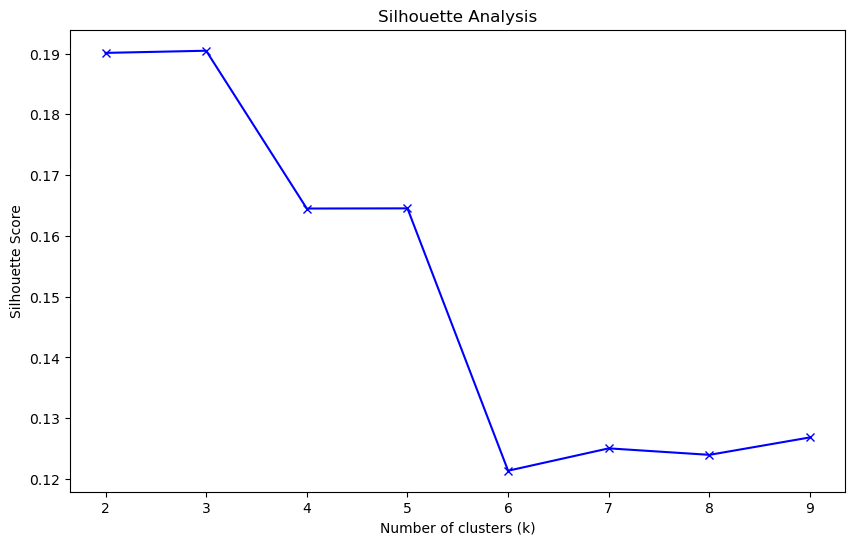

The optimal number of clusters is 3


In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import numpy as np

# Define a range of number of clusters to test
k_range = range(2, 10)

# Initialize empty lists to store the SSE and silhouette scores
sse = []
silhouette_scores = []

# Fit KMeans for each value of k
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_standardized)
    sse.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_standardized, kmeans.labels_))

# Plot the elbow curve
plt.plot(k_range, sse, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

# Plot the silhouette scores
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

# Find the optimal number of clusters based on the highest silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"The optimal number of clusters is {optimal_k}")

/rds/general/user/hg1222/home/anaconda3/envs/test1/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


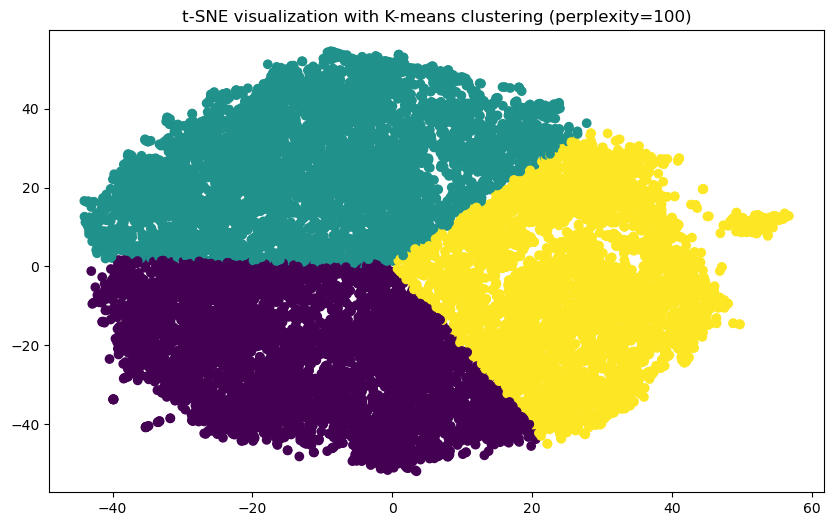

In [19]:
### try out k-means, mean shift, gaussian mixture and DBSCAN 
### the best perplexity value fot t-SNE(in this case, 100)

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# df_standardized is the high-dimensional data
perplexity = 100
tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
X_tsne = tsne.fit_transform(df_standardized)

# Cluster the transformed data using K-means, use elbow method and silhouette to determine the optimal number of clusters 
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_tsne)

# Plot the transformed data with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.title(f"t-SNE visualization with K-means clustering (perplexity={perplexity})")
plt.show()

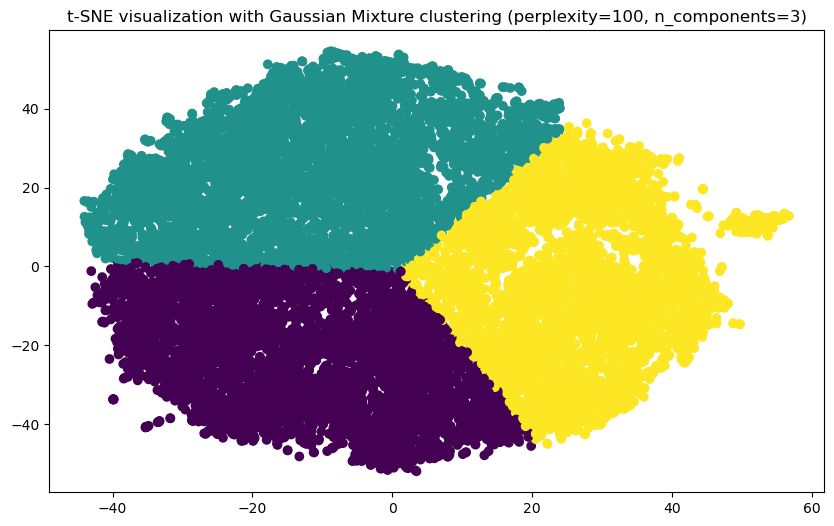

In [20]:
#### visualize on the Gaussian micture 
from sklearn.mixture import GaussianMixture

# Cluster the transformed data using Gaussian Mixture
n_components = 3
gmm = GaussianMixture(n_components=n_components, random_state=42)
labels = gmm.fit_predict(X_tsne)

# Plot the transformed data with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.title(f"t-SNE visualization with Gaussian Mixture clustering (perplexity={perplexity}, n_components={n_components})")
plt.show()


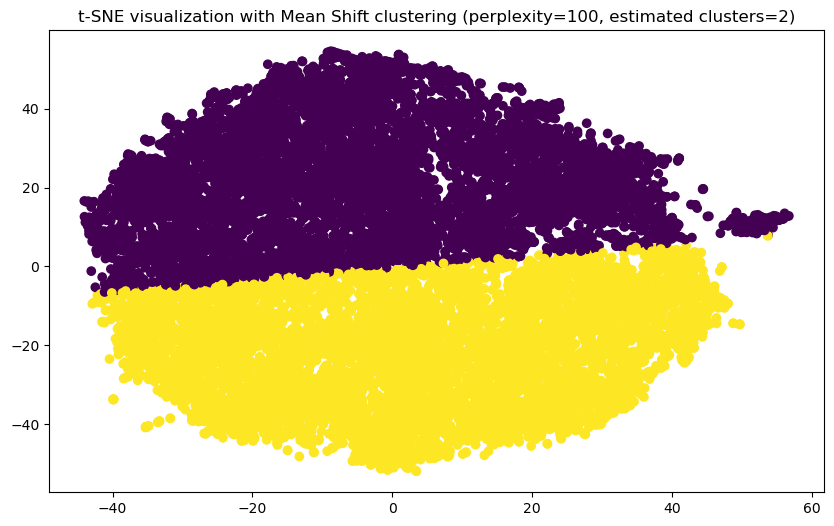

In [21]:
### mean shift 

from sklearn.cluster import MeanShift, estimate_bandwidth

# Estimate the bandwidth parameter for Mean Shift
bandwidth = estimate_bandwidth(X_tsne, quantile=0.2, n_samples=500)

# Cluster the transformed data using Mean Shift
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
labels = ms.fit_predict(X_tsne)
n_clusters_ = len(np.unique(labels))

# Plot the transformed data with different colors for each cluster
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.title(f"t-SNE visualization with Mean Shift clustering (perplexity={perplexity}, estimated clusters={n_clusters_})")
plt.show()


In [23]:
from sklearn.metrics import silhouette_score, homogeneity_score, completeness_score

# Evaluate the quality of K-means clustering
kmeans_silhouette = silhouette_score(X_tsne, kmeans.labels_)
kmeans_homogeneity = homogeneity_score(kmeans.labels_, kmeans.labels_)
kmeans_completeness = completeness_score(kmeans.labels_, kmeans.labels_)

# Evaluate the quality of Gaussian Mixture Model clustering
gmm_silhouette = silhouette_score(X_tsne, gmm.predict(X_tsne))
gmm_homogeneity = homogeneity_score(gmm.predict(X_tsne), gmm.predict(X_tsne))
gmm_completeness = completeness_score(gmm.predict(X_tsne), gmm.predict(X_tsne))

# Evaluate the quality of Mean Shift clustering
ms_silhouette = silhouette_score(X_tsne, ms.labels_)
ms_homogeneity = homogeneity_score(ms.labels_, ms.labels_)
ms_completeness = completeness_score(ms.labels_, ms.labels_)

# Print the evaluation metrics for each clustering method
print("K-means clustering evaluation:")
print(f"Silhouette score: {kmeans_silhouette:.3f}")
print(f"Homogeneity score: {kmeans_homogeneity:.3f}")
print(f"Completeness score: {kmeans_completeness:.3f}\n")

print("Gaussian Mixture Model clustering evaluation:")
print(f"Silhouette score: {gmm_silhouette:.3f}")
print(f"Homogeneity score: {gmm_homogeneity:.3f}")
print(f"Completeness score: {gmm_completeness:.3f}\n")

print("Mean Shift clustering evaluation:")
print(f"Silhouette score: {ms_silhouette:.3f}")
print(f"Homogeneity score: {ms_homogeneity:.3f}")
print(f"Completeness score: {ms_completeness:.3f}\n")


K-means clustering evaluation:
Silhouette score: 0.392
Homogeneity score: 1.000
Completeness score: 1.000

Gaussian Mixture Model clustering evaluation:
Silhouette score: 0.392
Homogeneity score: 1.000
Completeness score: 1.000

Mean Shift clustering evaluation:
Silhouette score: 0.376
Homogeneity score: 1.000
Completeness score: 1.000



by comparing the the sohouette score, it seems like K-means and gaussian mixture have the same score, 

### k - means has the best performance

In [24]:
# Add the cluster labels as a new column
df_standardized['cluster_kmeans'] = kmeans.labels_

In [26]:
print(df_standardized)

       Lymphocyte_count.0.0  Monocyte_count.0.0  Reti_count.0.0  \
0                  0.101115            0.000724        0.380855   
1                  1.352502           -0.097026       -0.584809   
2                 -0.089314           -0.097026        0.187722   
3                  0.373155            0.098473        0.270493   
4                  1.298094            0.049599       -0.557218   
...                     ...                 ...             ...   
14620             -0.143722           -0.009051        0.518807   
14621              0.073910            0.196223       -0.308905   
14622             -0.143722            0.000724       -0.419266   
14623              0.335070           -0.292524       -0.612399   
14624             -0.143722           -0.194775       -0.308905   

       WBC_count.0.0  RBC_count.0.0  Hgb_conc.0.0  Haematocrit_perc.0.0  \
0           0.195336       0.901972     -0.088446              0.017708   
1           1.362884       0.381643     -0.58

In [27]:
# Calculate the mean values of features for each cluster
cluster_means = df_standardized.groupby('cluster_kmeans')['Lymphocyte_count.0.0', 'Monocyte_count.0.0', 'Reti_count.0.0', 'WBC_count.0.0', 'Basophil_count.0.0', 'Eosinophil_count.0.0', 'Neutrophil_count.0.0', 'Immature_ret_fraction.0.0', 'High_light_scatter_reti_count.0.0' ].mean()

print(cluster_means)

                Lymphocyte_count.0.0  Monocyte_count.0.0  Reti_count.0.0  \
cluster_kmeans                                                             
0                          -0.086463           -0.005494       -0.108894   
1                          -0.074091           -0.060848       -0.384058   
2                           0.186012            0.080099        0.587883   

                WBC_count.0.0  Basophil_count.0.0  Eosinophil_count.0.0  \
cluster_kmeans                                                            
0                   -0.092269           -0.089255              0.264043   
1                   -0.141092           -0.107224             -0.248224   
2                    0.273941            0.229406              0.009038   

                Neutrophil_count.0.0  Immature_ret_fraction.0.0  \
cluster_kmeans                                                    
0                          -0.110605                  -0.455056   
1                          -0.215515      

/var/tmp/pbs.7105000.pbs/ipykernel_728065/1256921978.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  cluster_means = df_standardized.groupby('cluster_kmeans')['Lymphocyte_count.0.0', 'Monocyte_count.0.0', 'Reti_count.0.0', 'WBC_count.0.0', 'Basophil_count.0.0', 'Eosinophil_count.0.0', 'Neutrophil_count.0.0', 'Immature_ret_fraction.0.0', 'High_light_scatter_reti_count.0.0' ].mean()


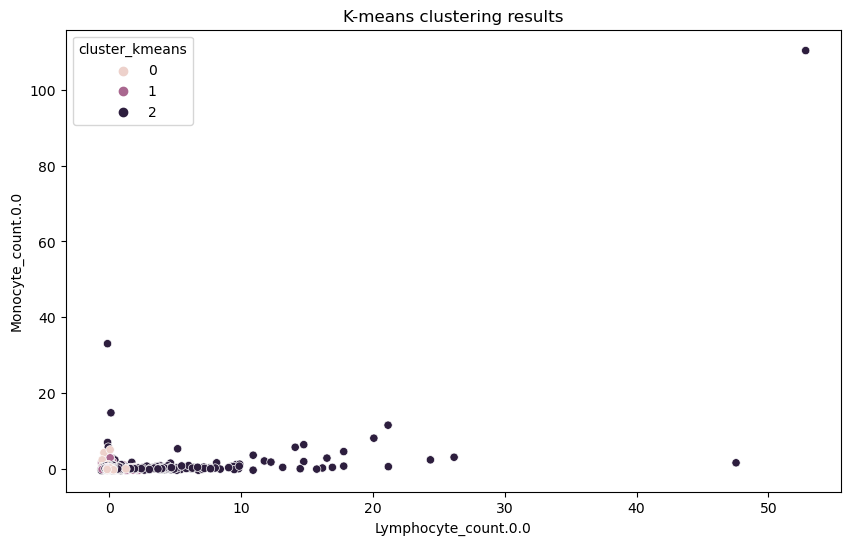

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Monocyte_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Monocyte_count.0.0')
plt.show()


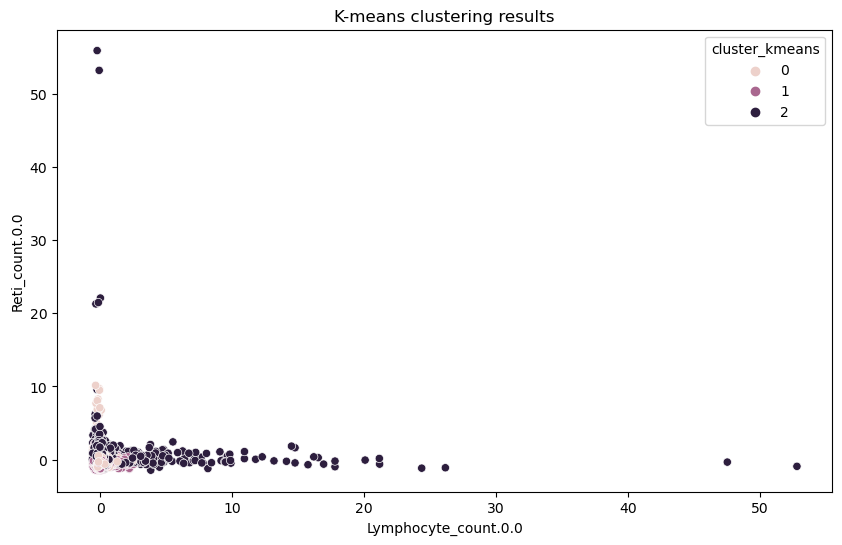

In [30]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Reti_count.0.0')
plt.show()

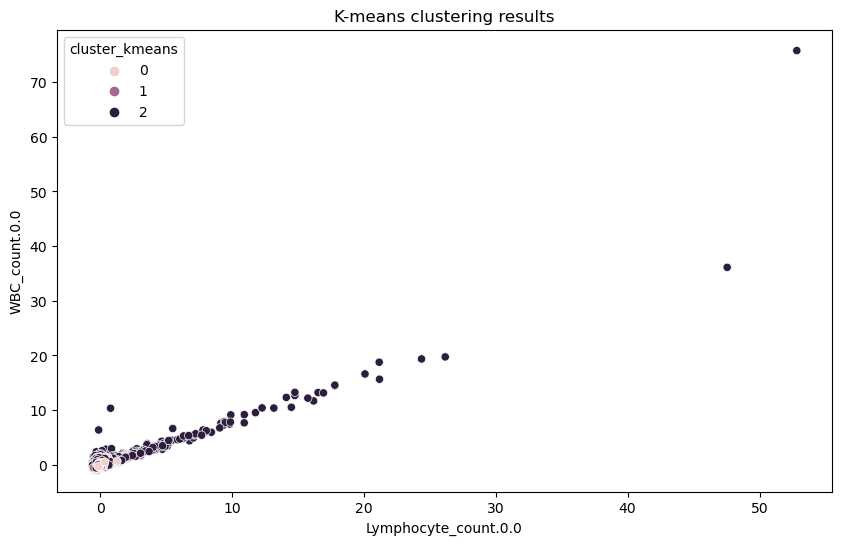

In [31]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='WBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('WBC_count.0.0')
plt.show()

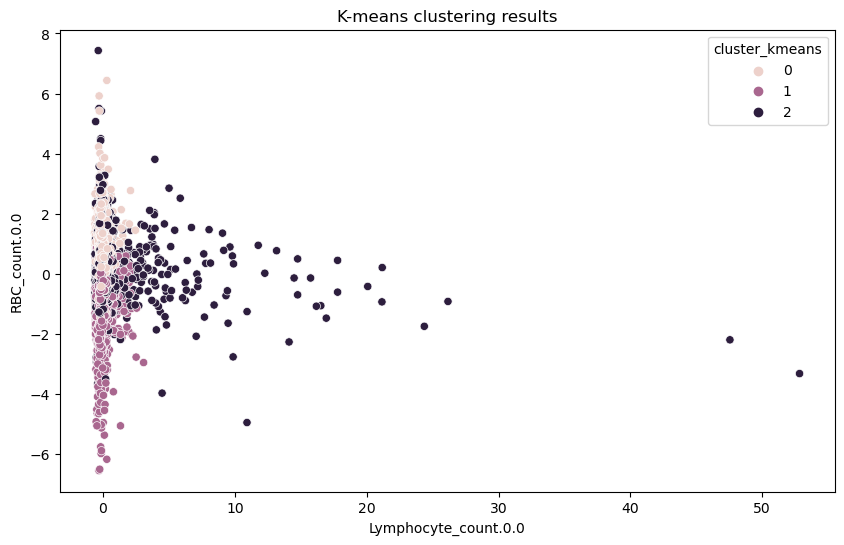

In [32]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='RBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('RBC_count.0.0')
plt.show()

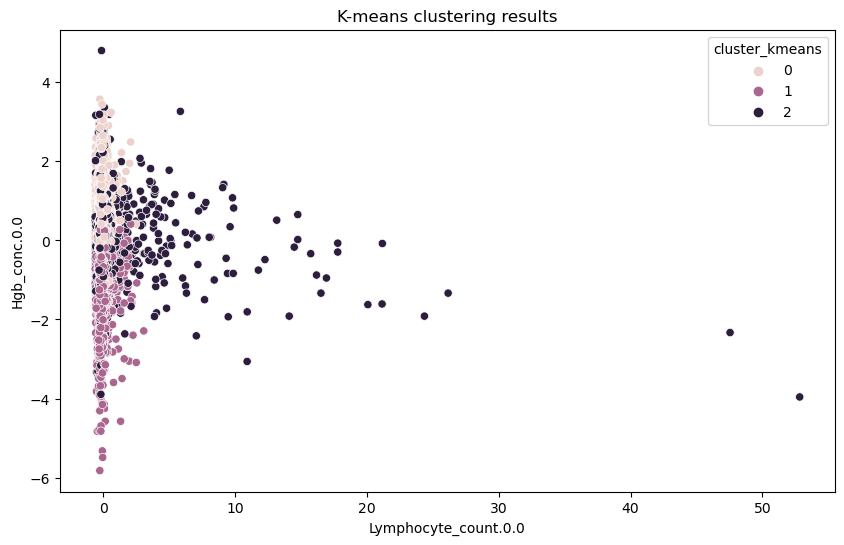

In [33]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Hgb_conc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Hgb_conc.0.0')
plt.show()

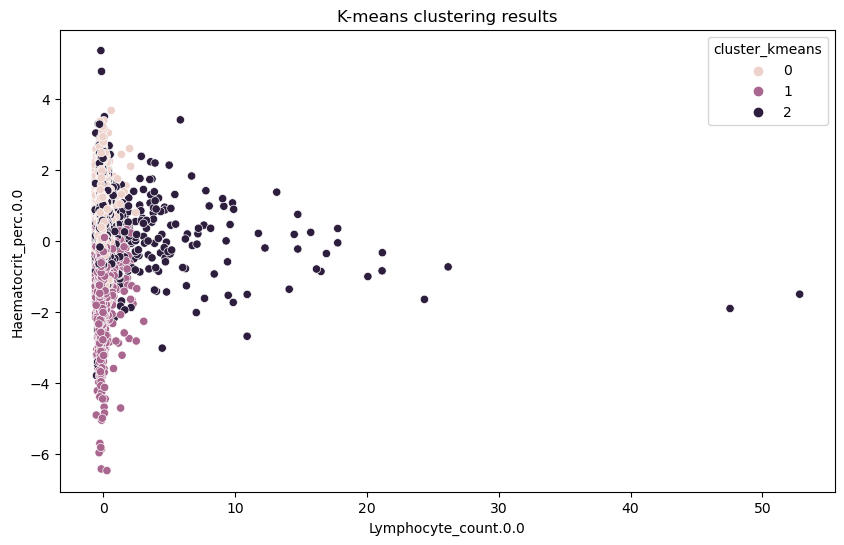

In [34]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Haematocrit_perc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Haematocrit_perc.0.0')
plt.show()

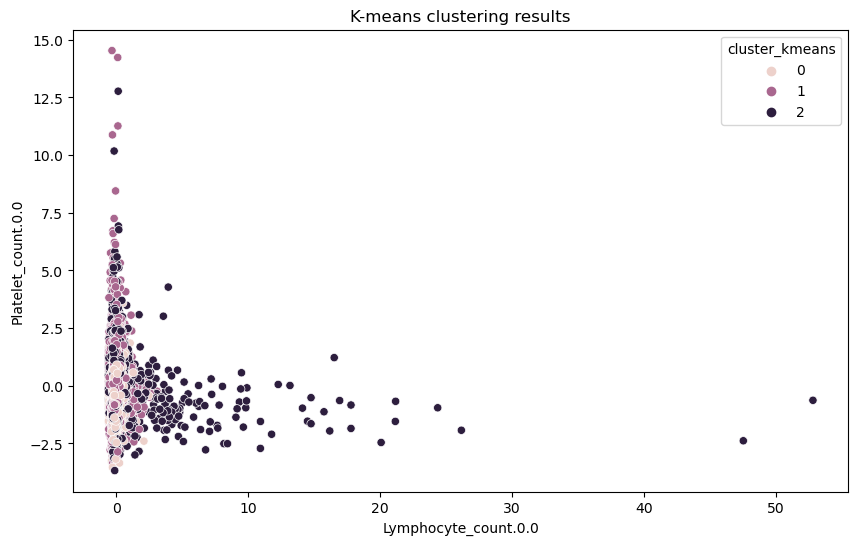

In [35]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

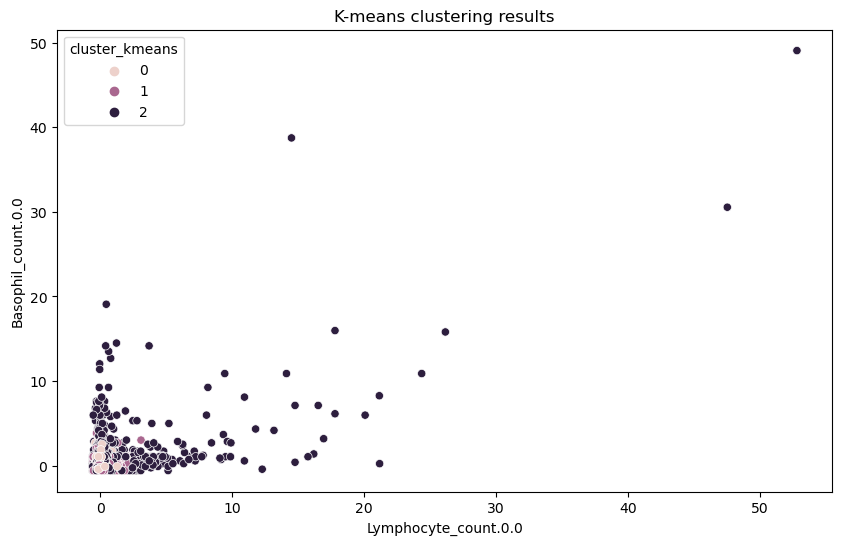

In [36]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

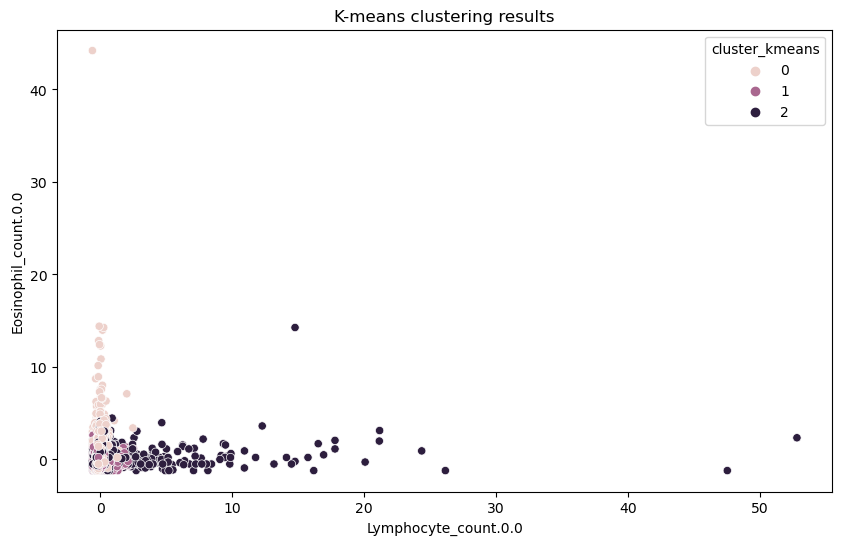

In [37]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

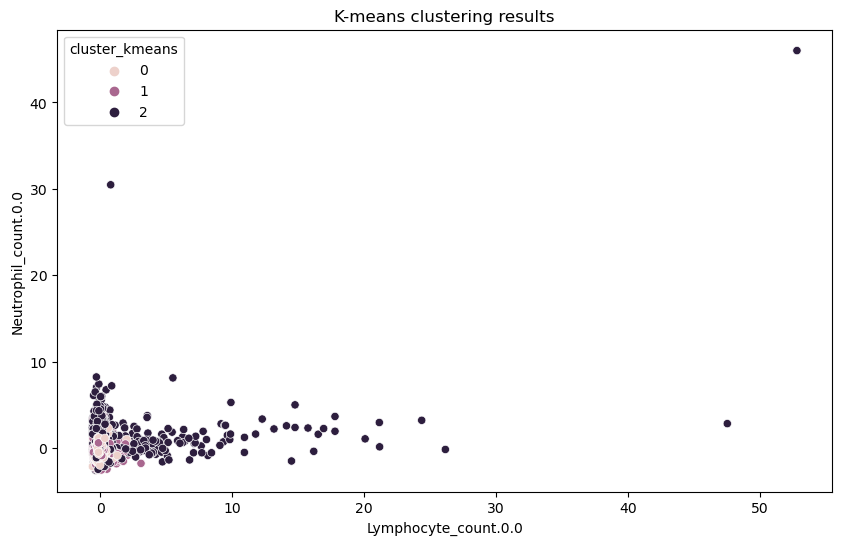

In [38]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

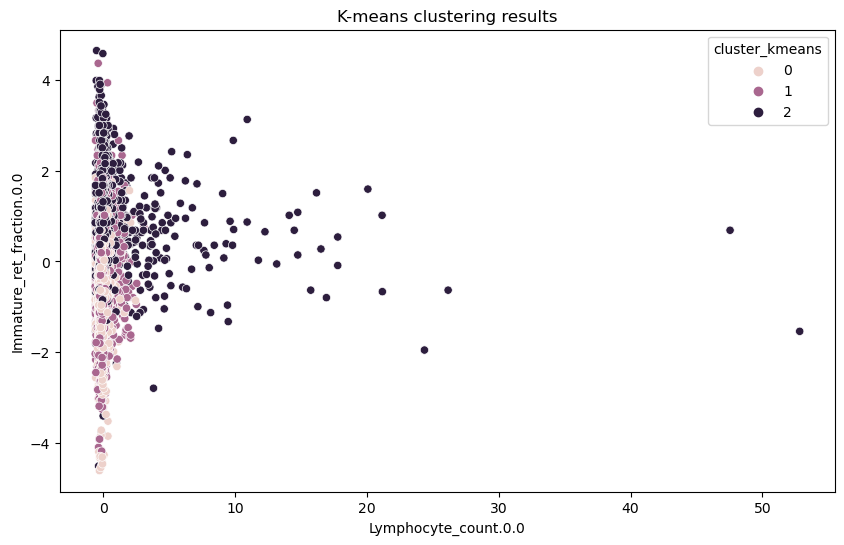

In [39]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

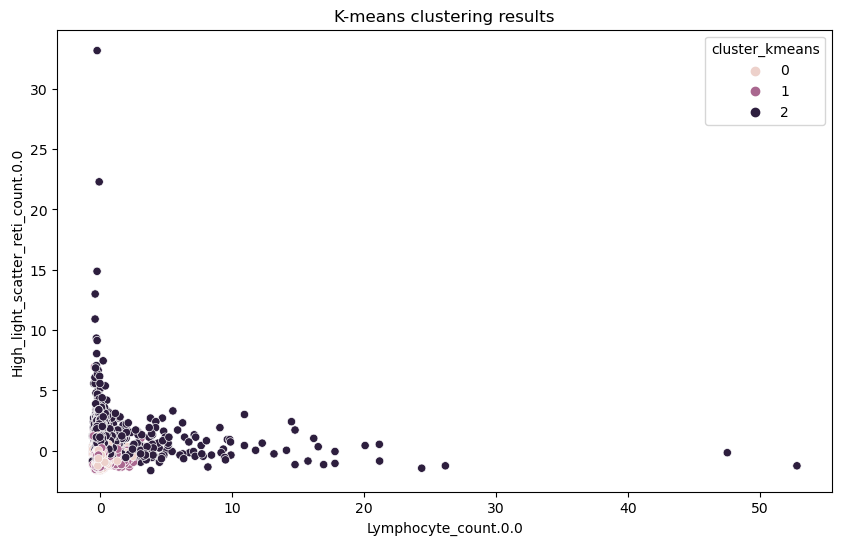

In [40]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Lymphocyte_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

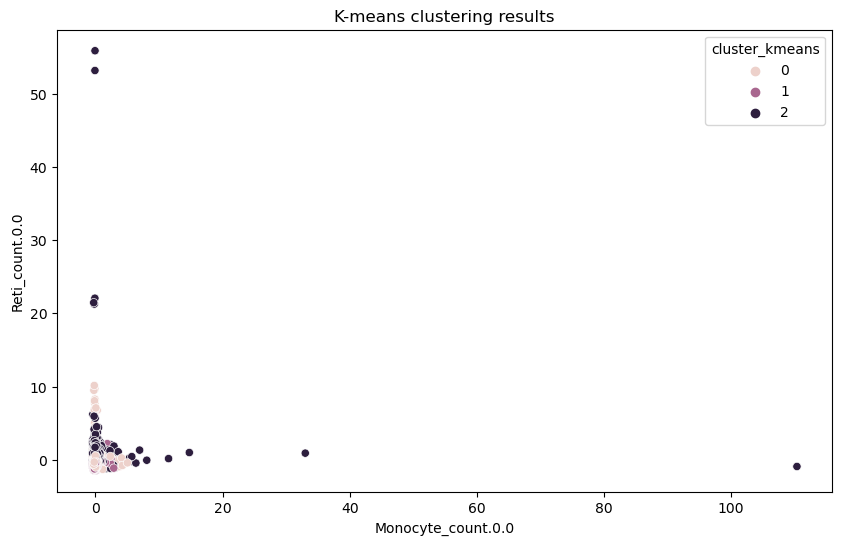

In [41]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Reti_count.0.0')
plt.show()

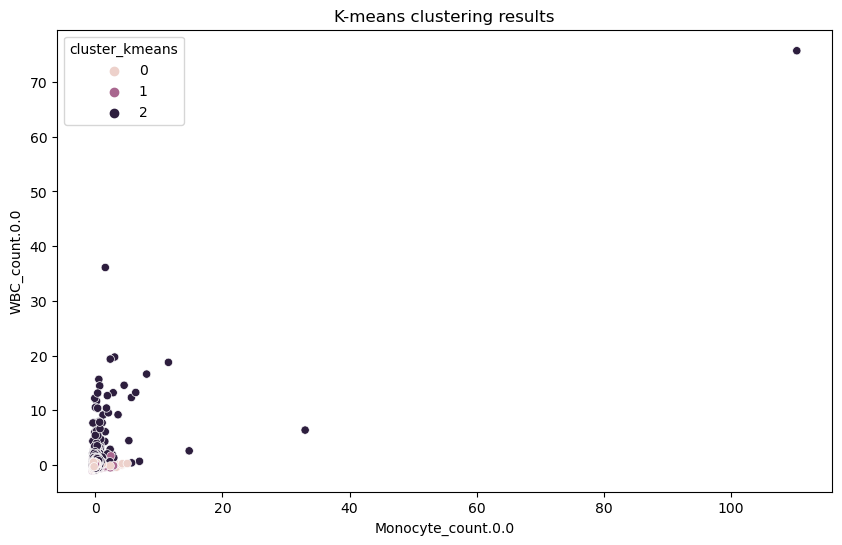

In [42]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='WBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('WBC_count.0.0')
plt.show()

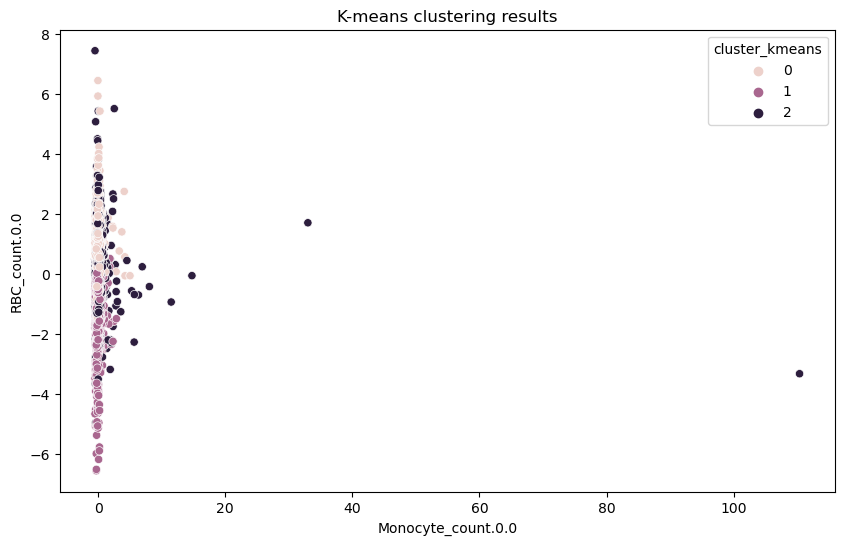

In [43]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='RBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('RBC_count.0.0')
plt.show()

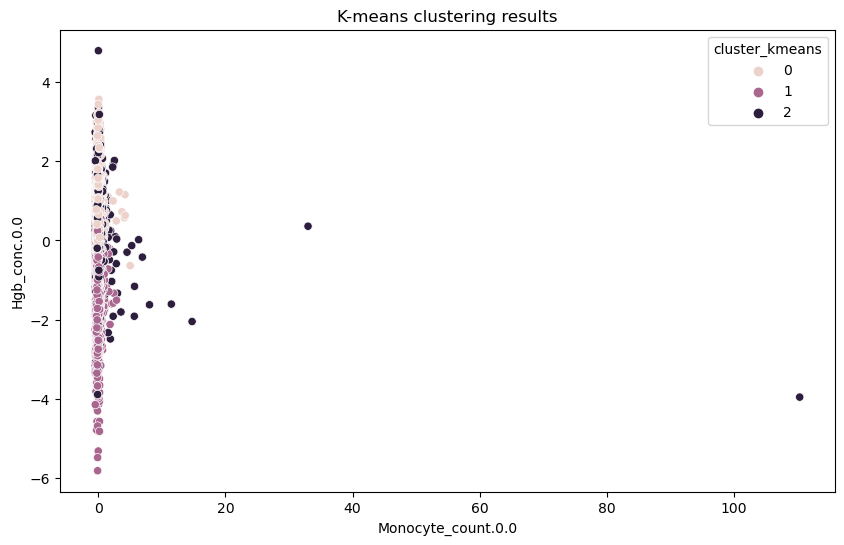

In [44]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Hgb_conc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Hgb_conc.0.0')
plt.show()

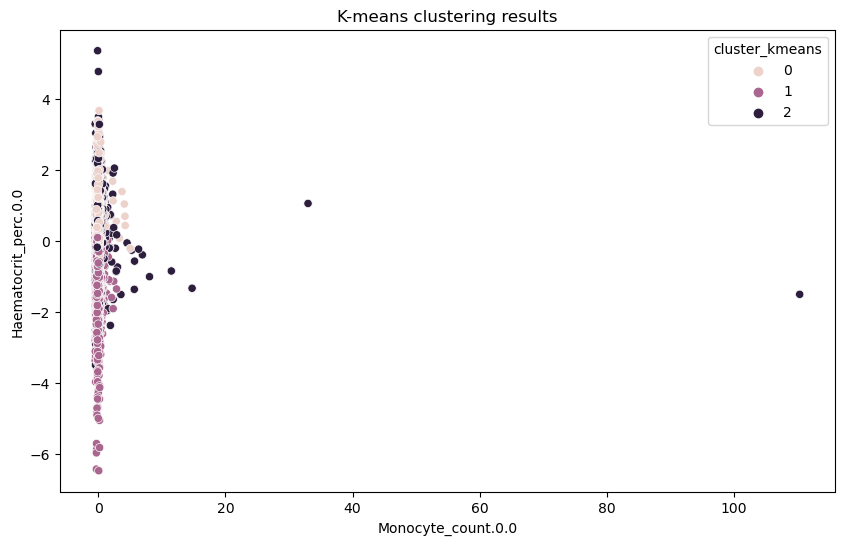

In [45]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Haematocrit_perc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Haematocrit_perc.0.0')
plt.show()

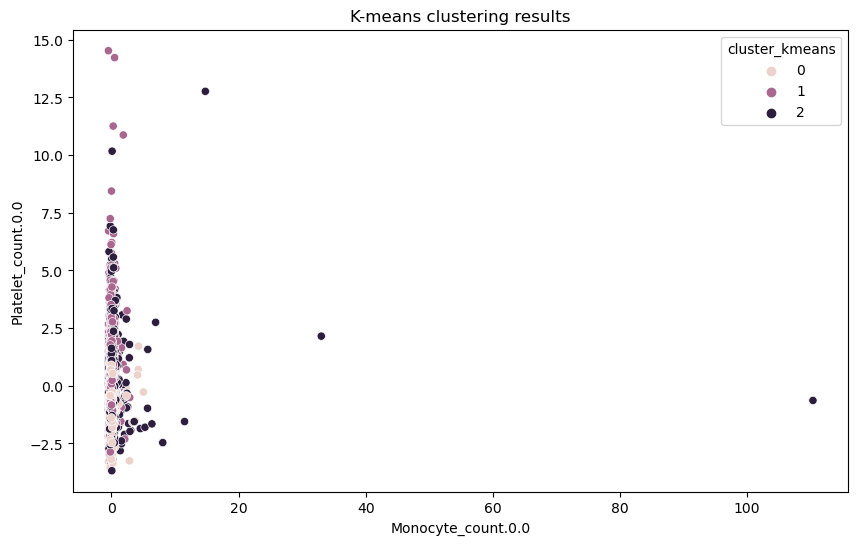

In [46]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

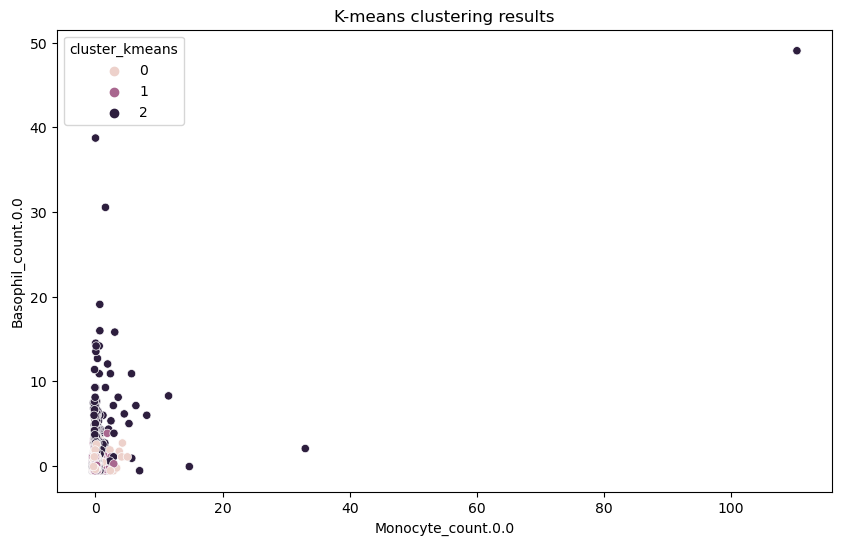

In [47]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

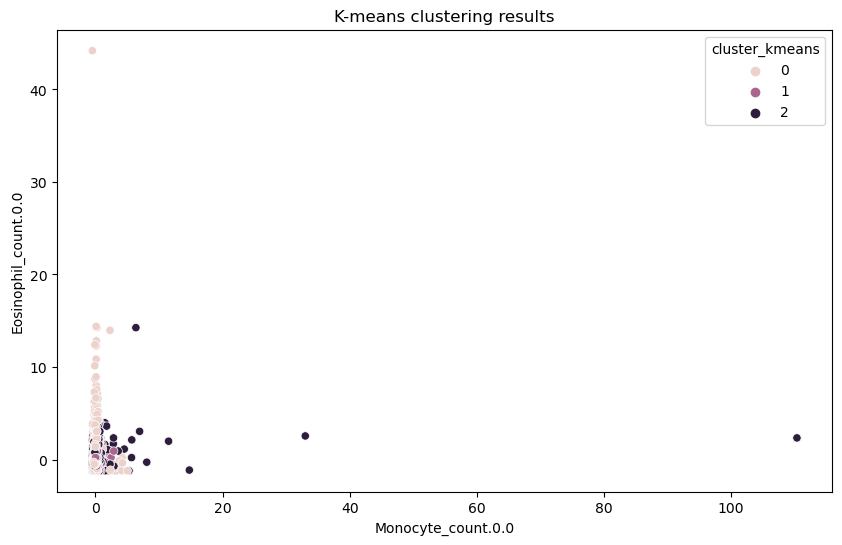

In [48]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

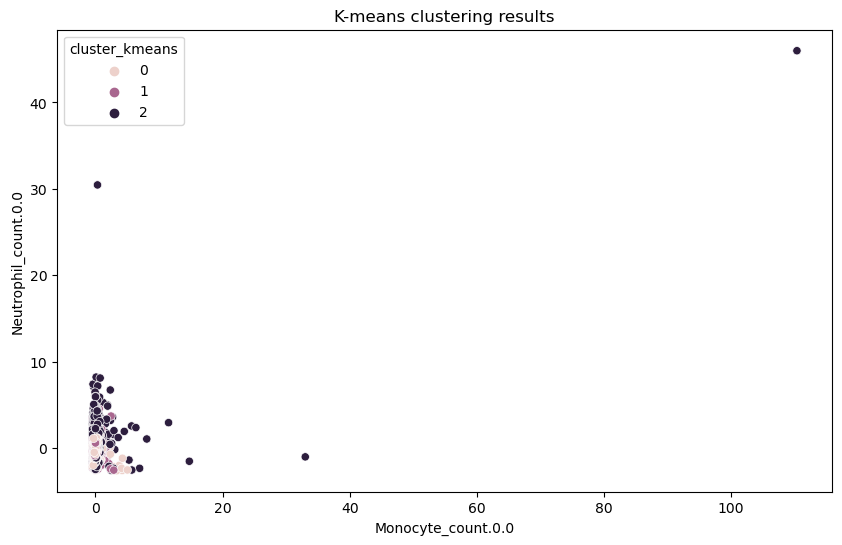

In [49]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

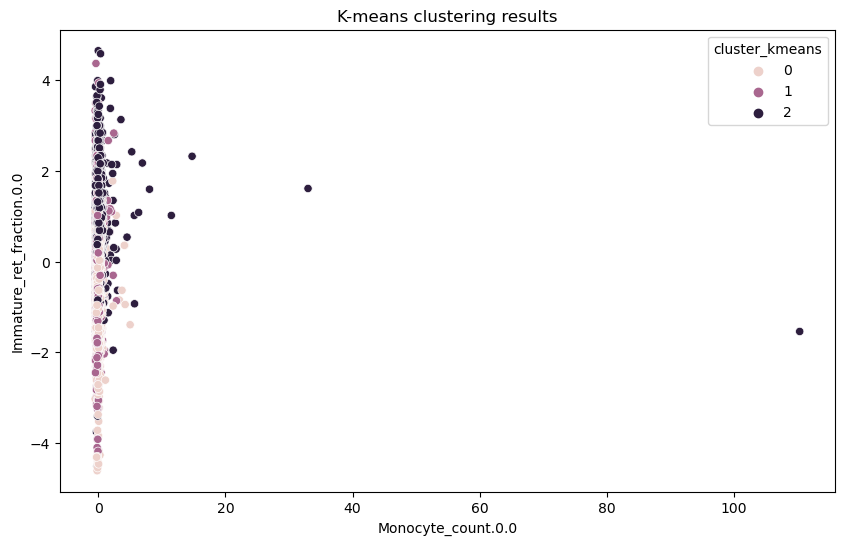

In [50]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

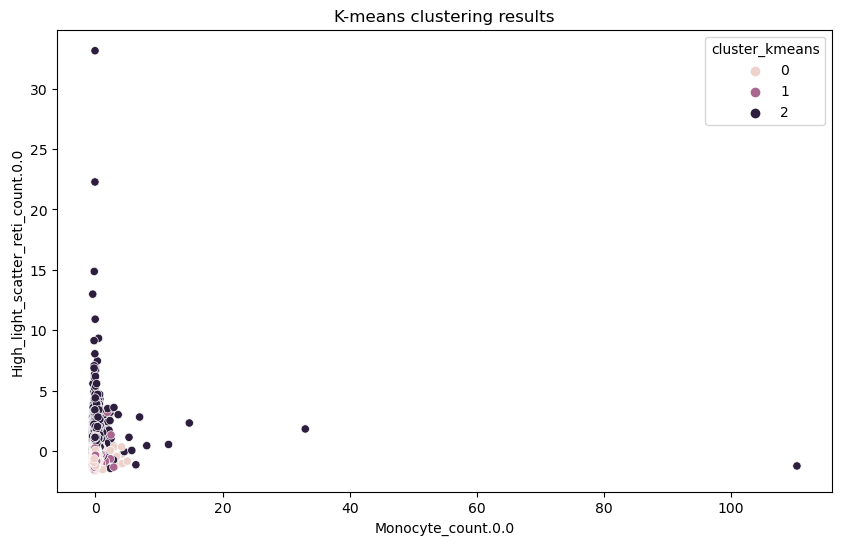

In [51]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Monocyte_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Monocyte_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

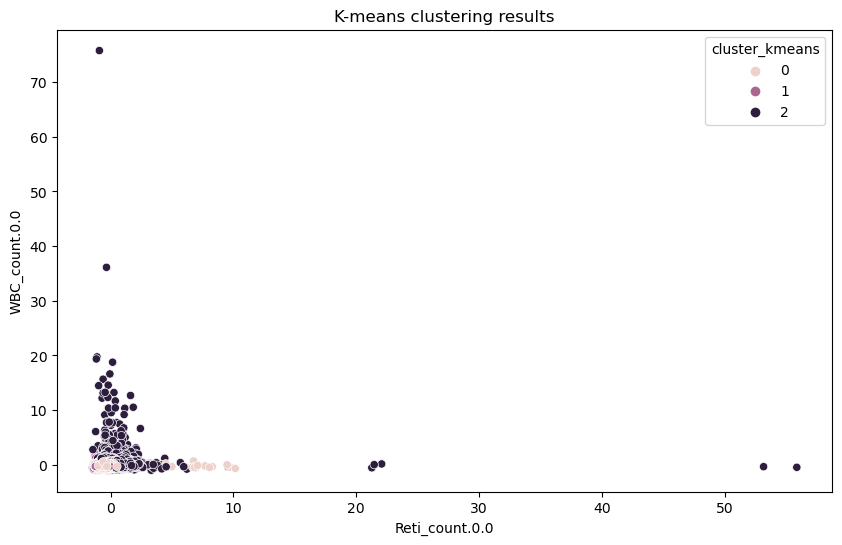

In [52]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='WBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('WBC_count.0.0')
plt.show()

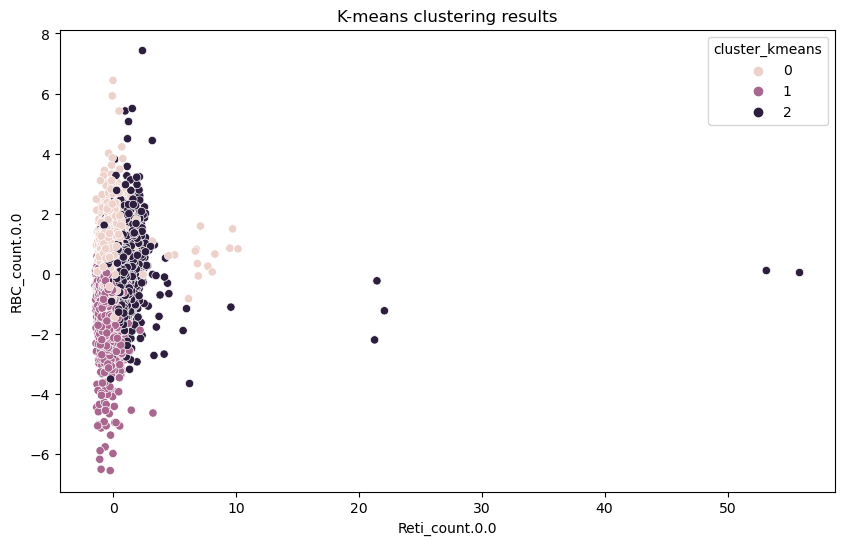

In [53]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='RBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('RBC_count.0.0')
plt.show()

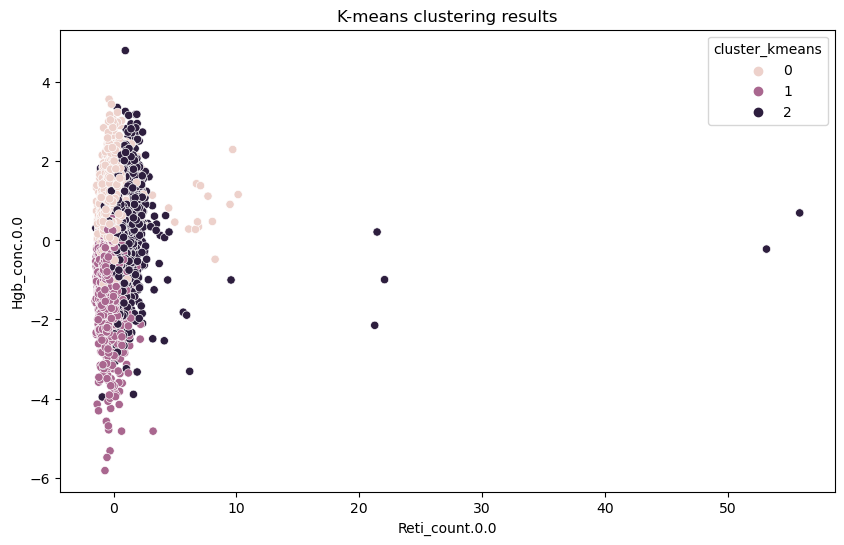

In [54]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Hgb_conc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Hgb_conc.0.0')
plt.show()

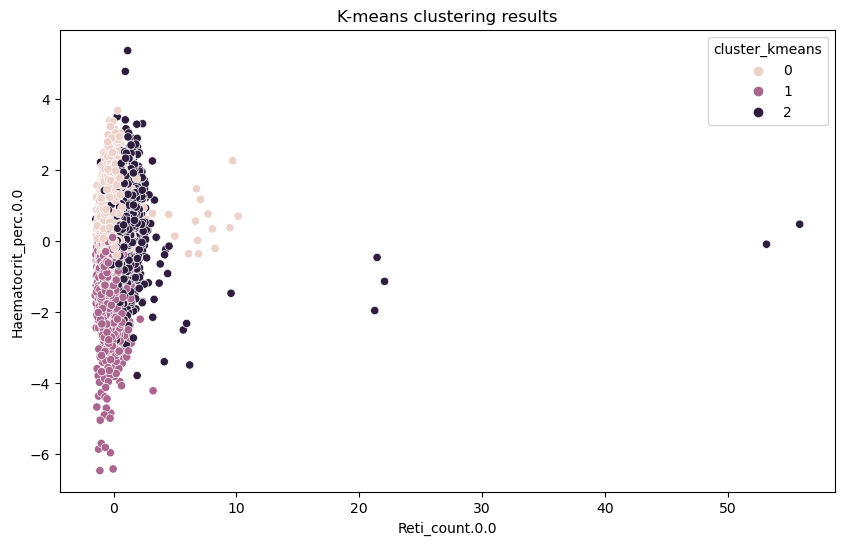

In [55]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Haematocrit_perc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Haematocrit_perc.0.0')
plt.show()

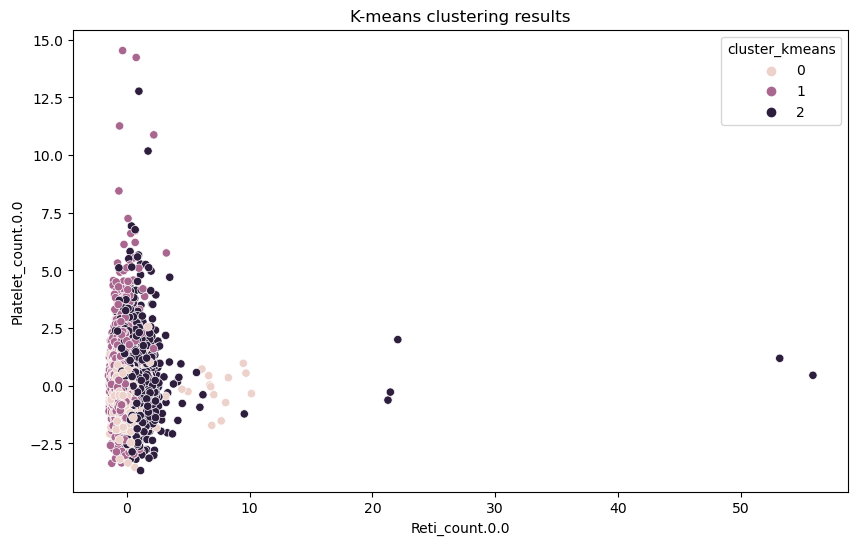

In [56]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

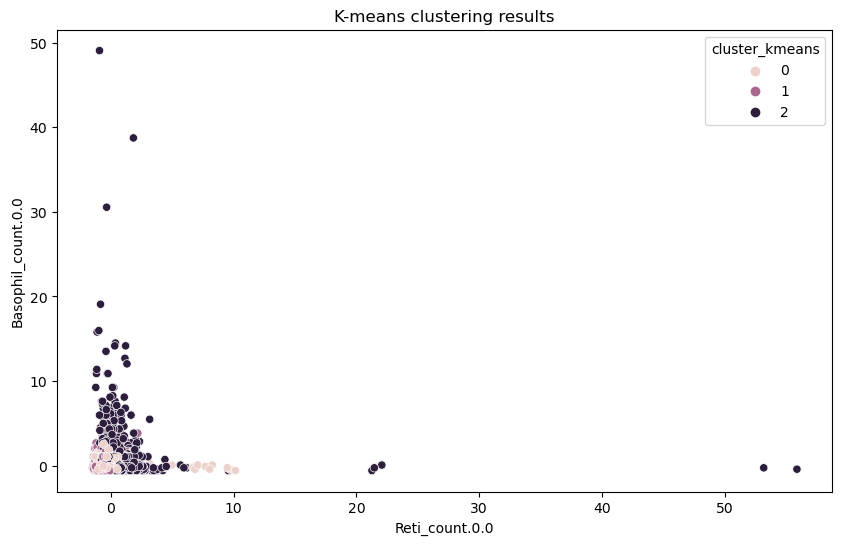

In [57]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

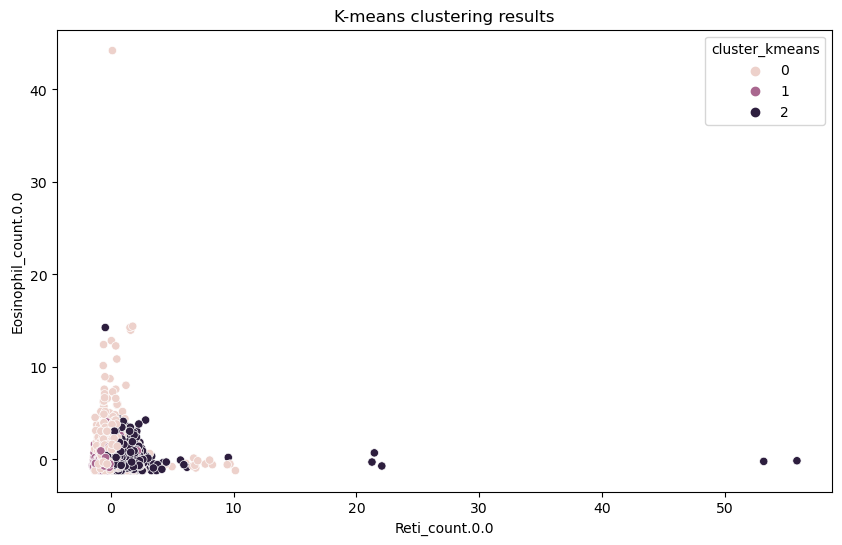

In [58]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

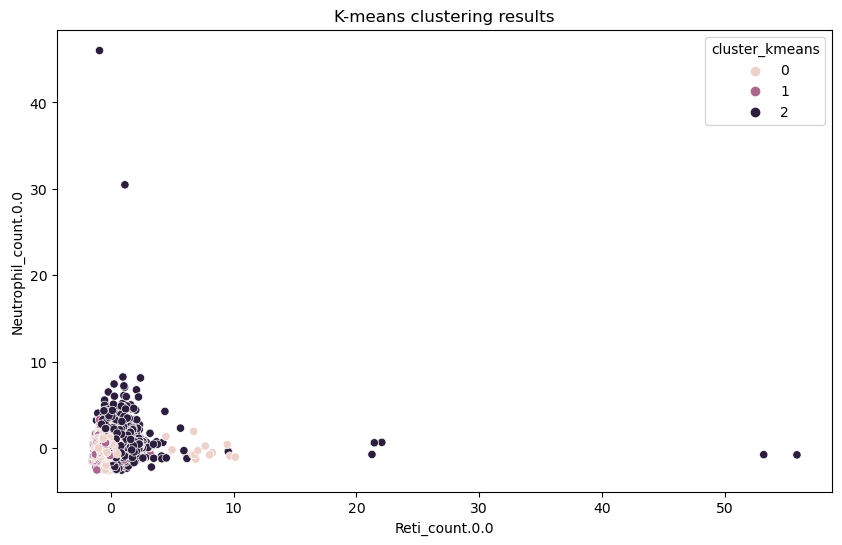

In [59]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

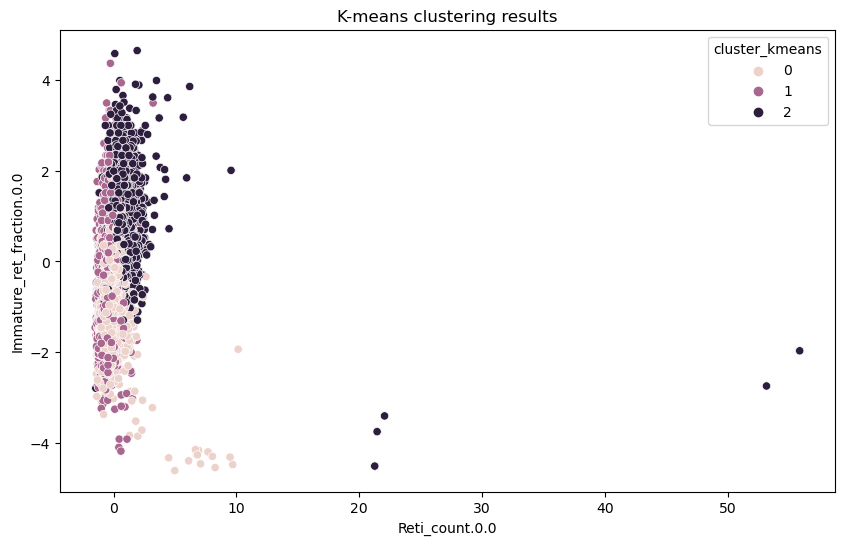

In [60]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

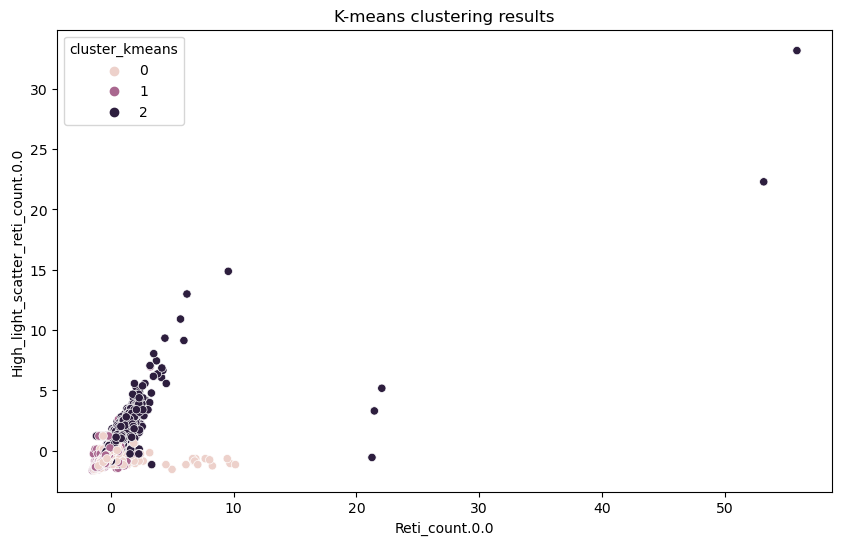

In [61]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Reti_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Reti_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

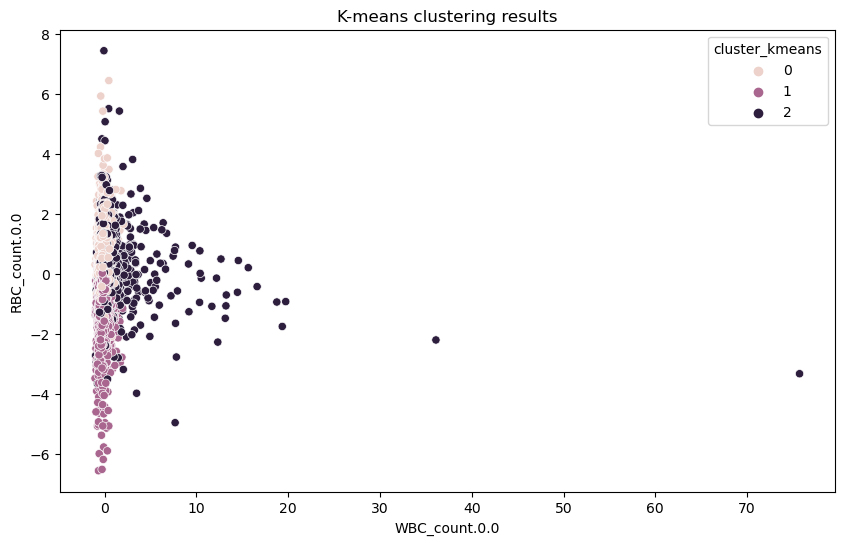

In [63]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='RBC_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('RBC_count.0.0')
plt.show()

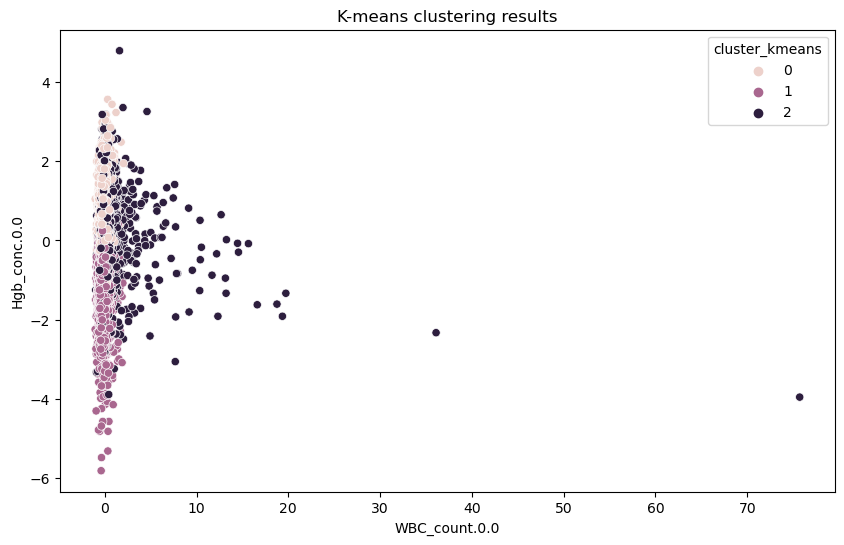

In [64]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Hgb_conc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Hgb_conc.0.0')
plt.show()

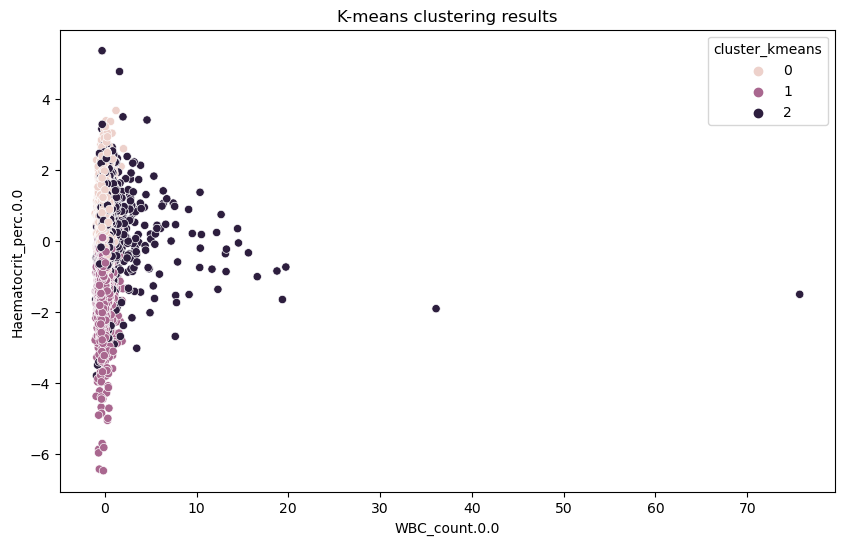

In [65]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Haematocrit_perc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Haematocrit_perc.0.0')
plt.show()

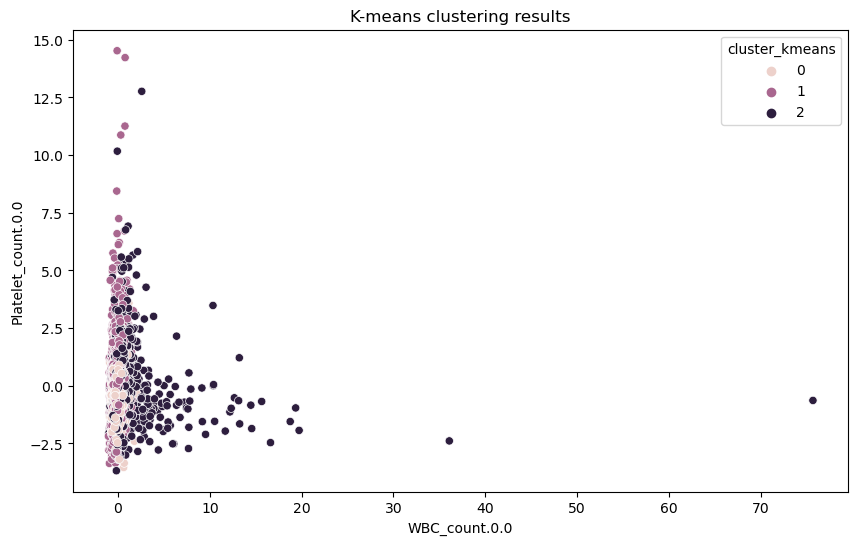

In [66]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

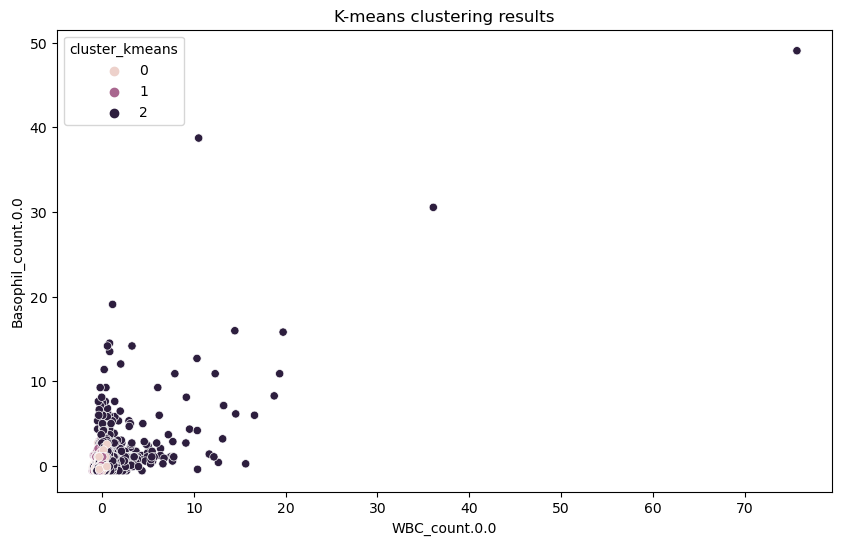

In [67]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

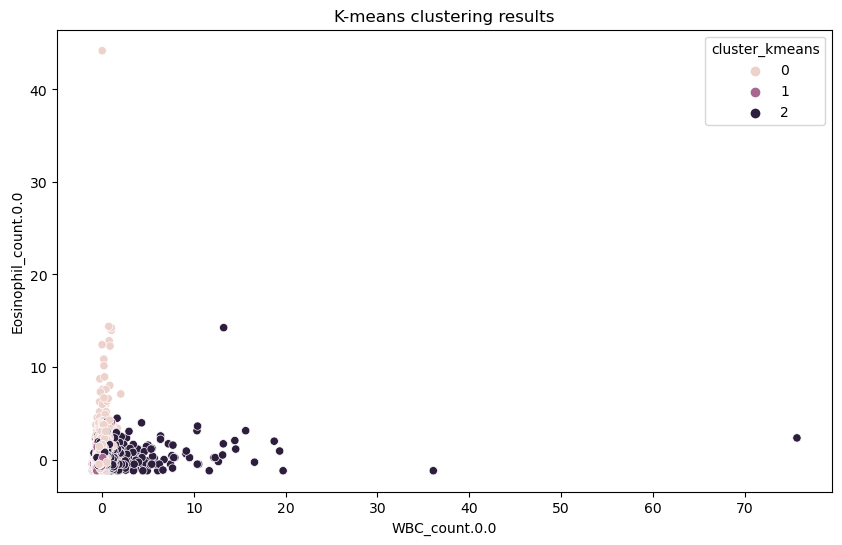

In [68]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

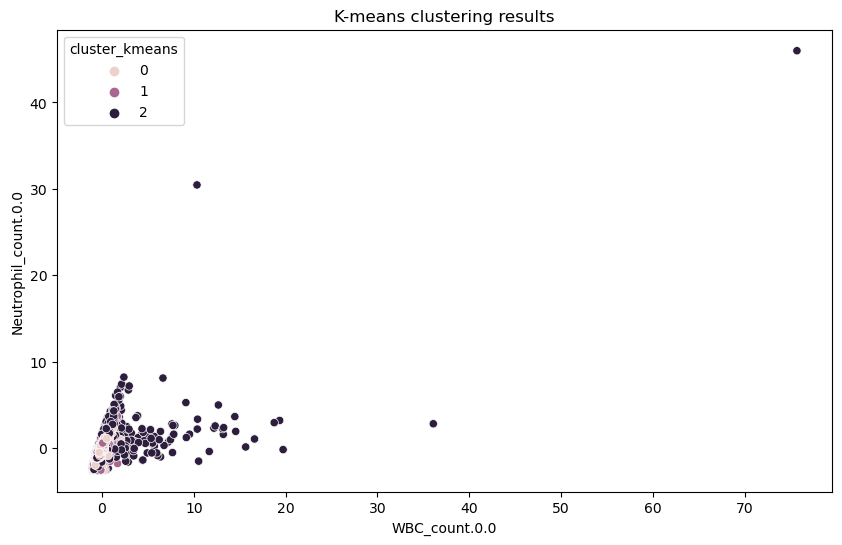

In [69]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

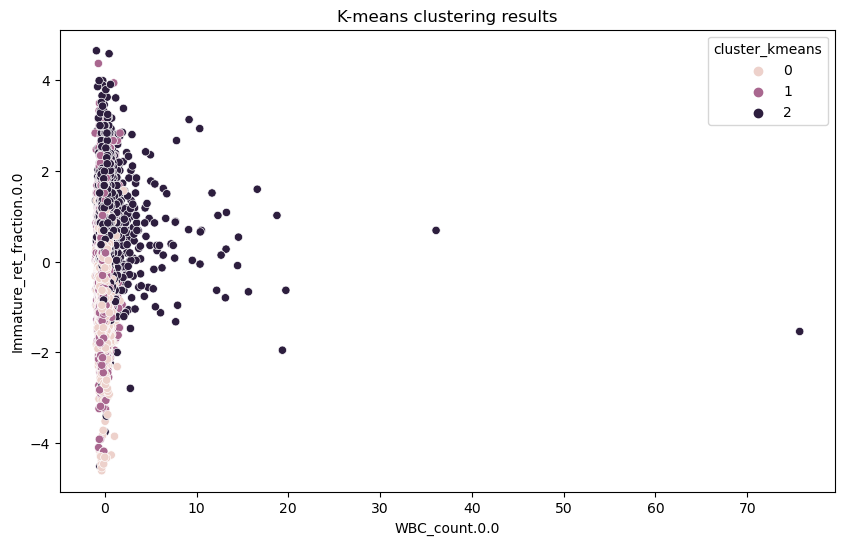

In [70]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

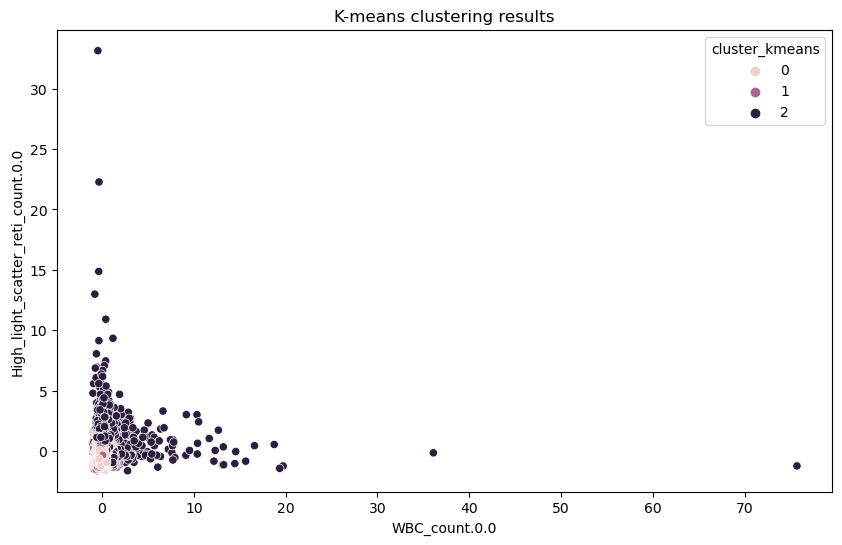

In [71]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='WBC_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('WBC_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

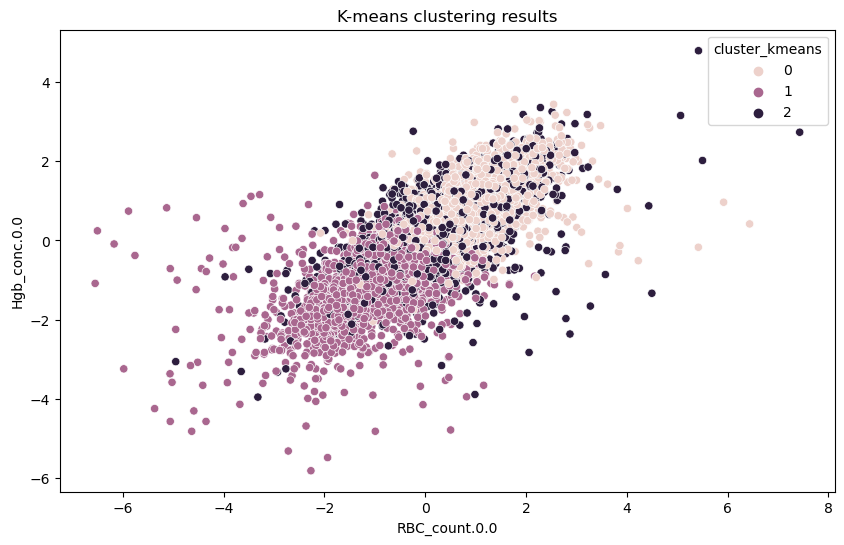

In [72]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Hgb_conc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Hgb_conc.0.0')
plt.show()

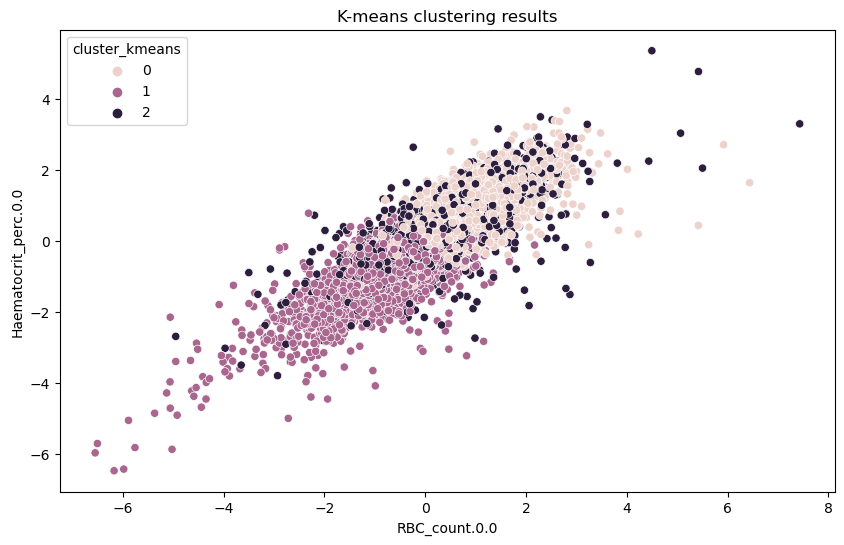

In [73]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Haematocrit_perc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Haematocrit_perc.0.0')
plt.show()

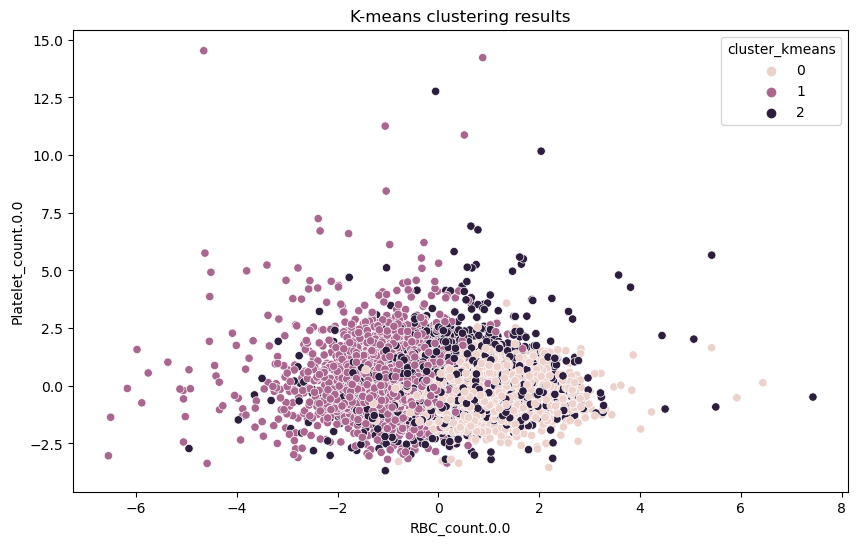

In [74]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

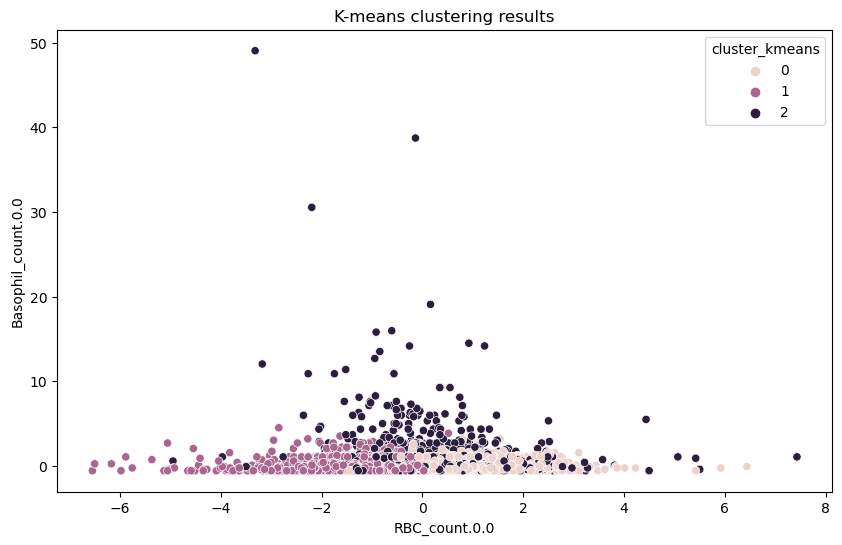

In [75]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

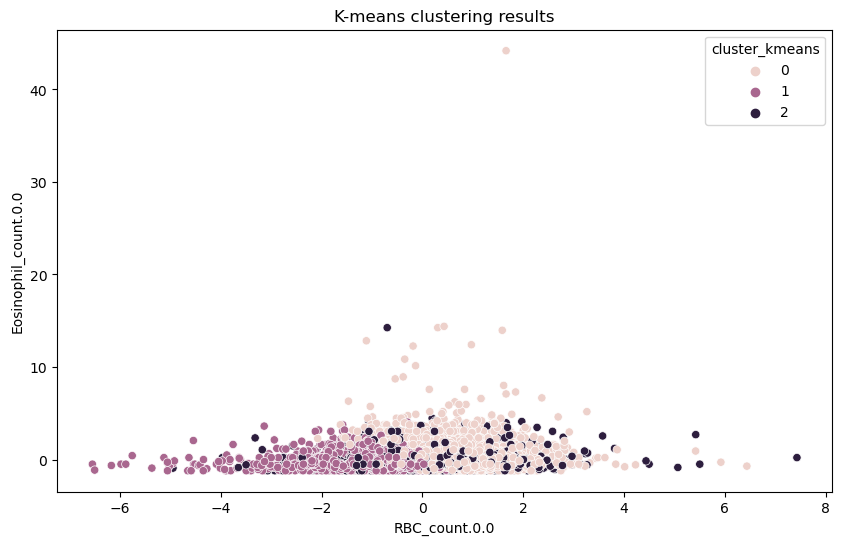

In [76]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

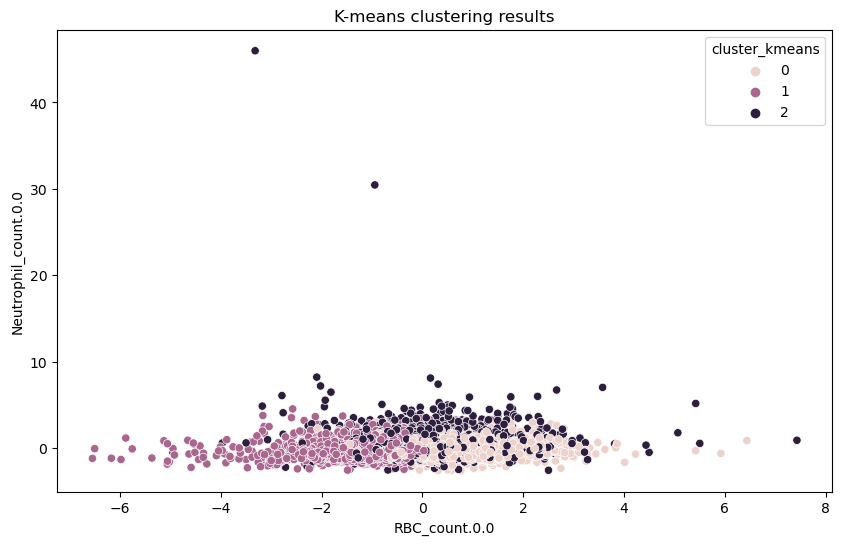

In [77]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

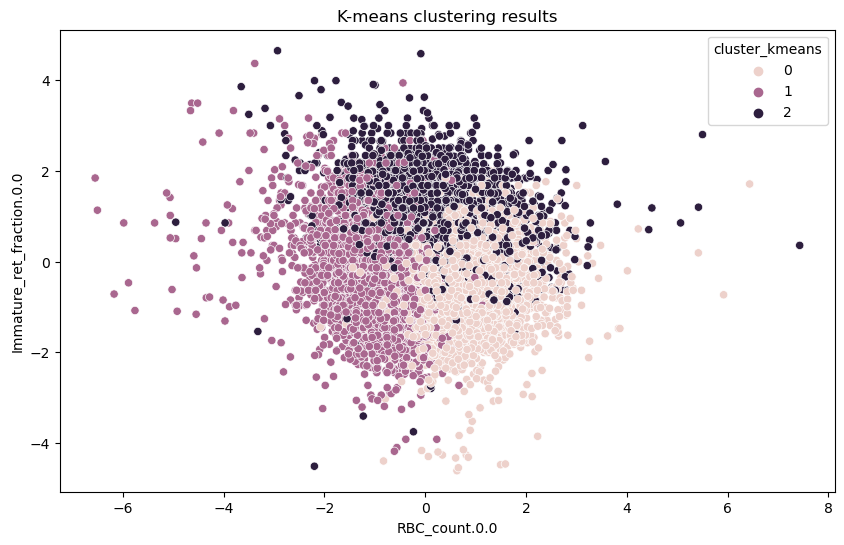

In [78]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

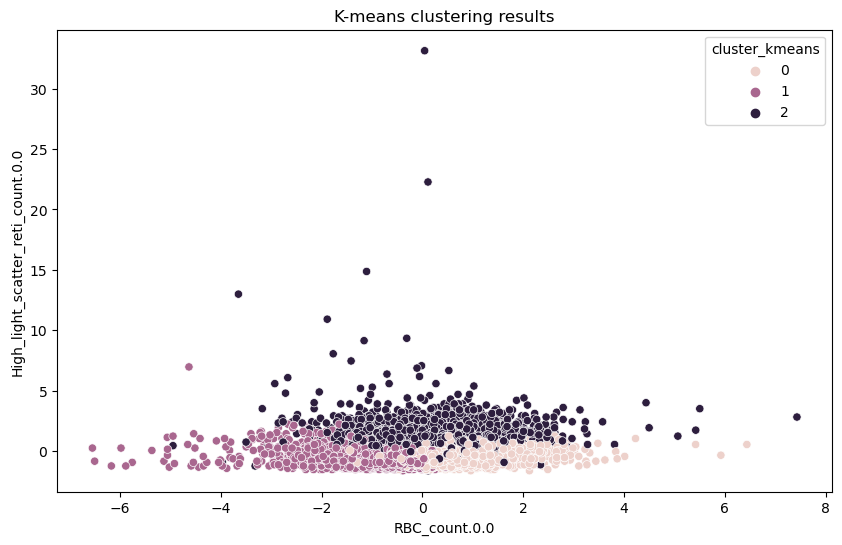

In [79]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='RBC_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('RBC_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

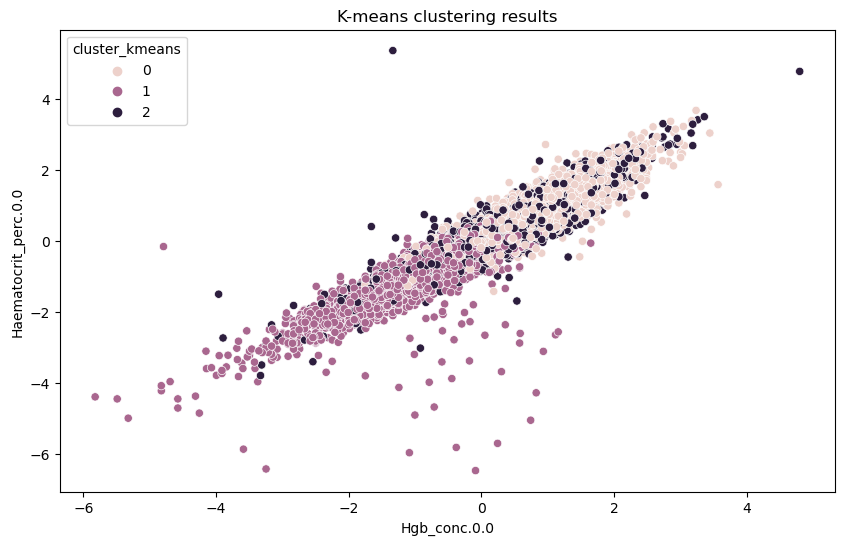

In [80]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Haematocrit_perc.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Haematocrit_perc.0.0')
plt.show()

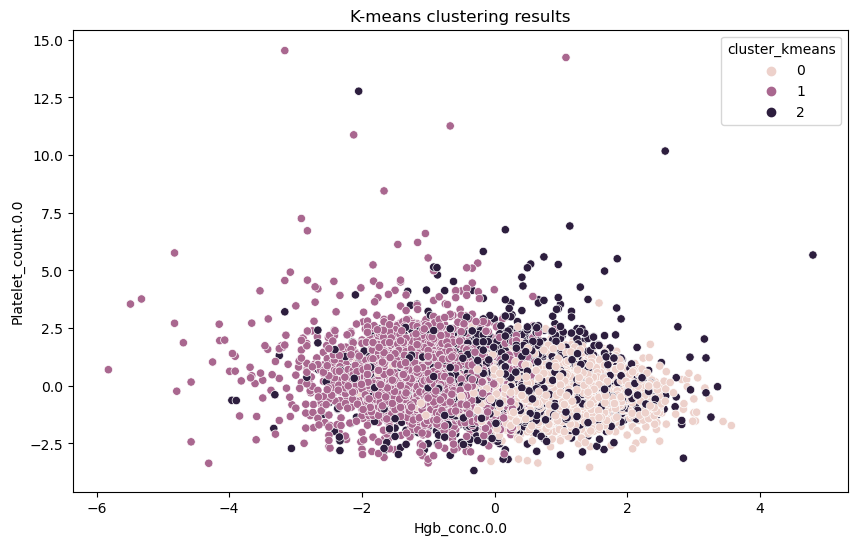

In [81]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

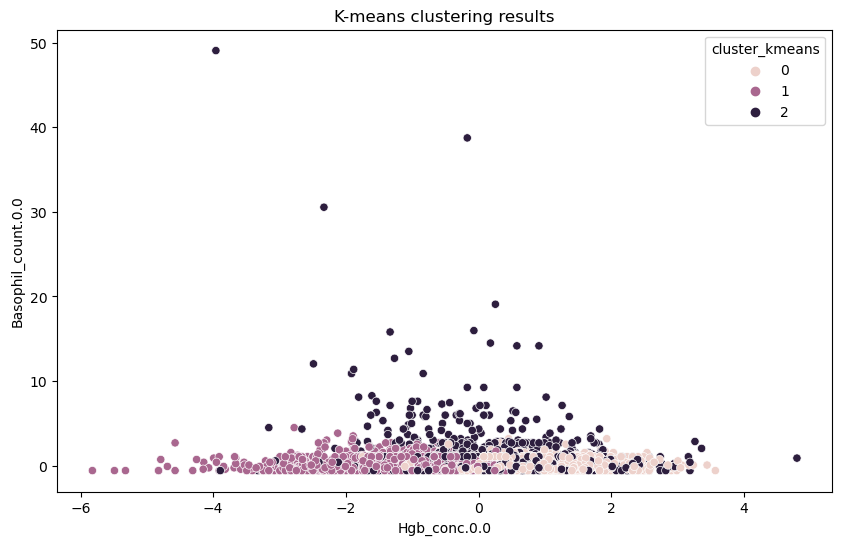

In [82]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

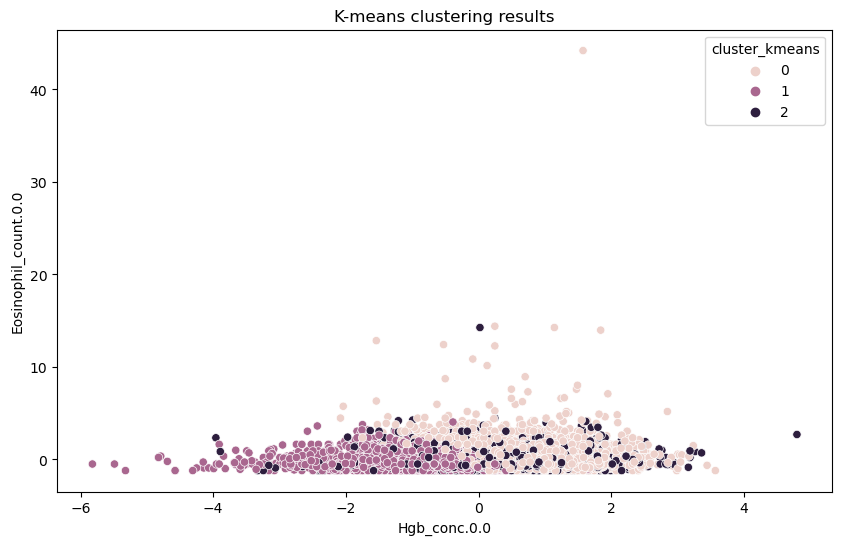

In [83]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

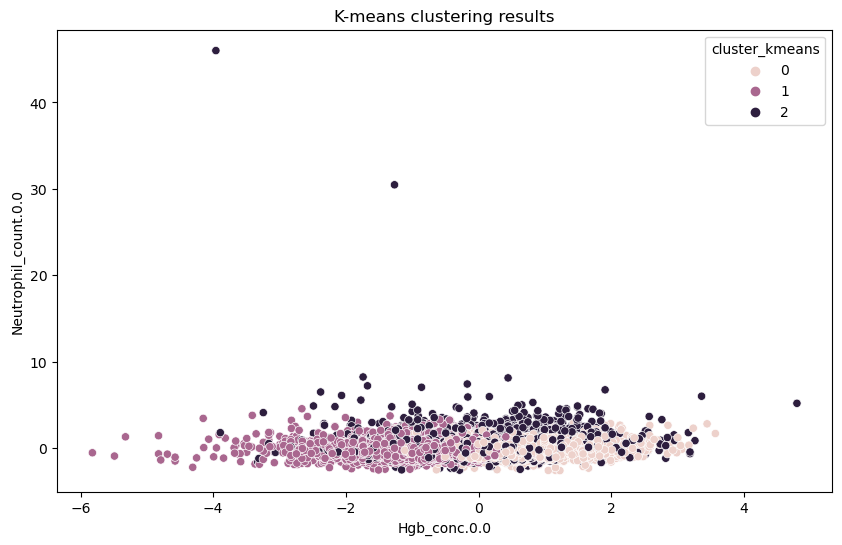

In [84]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

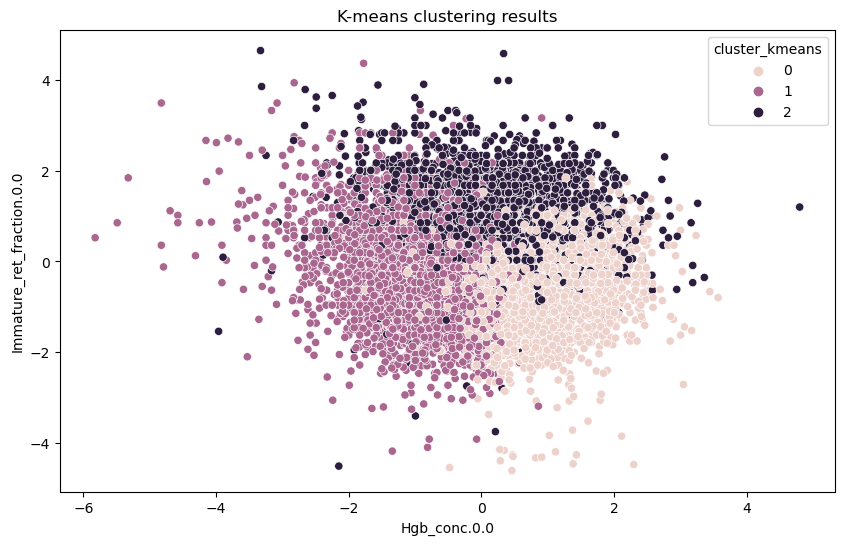

In [85]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

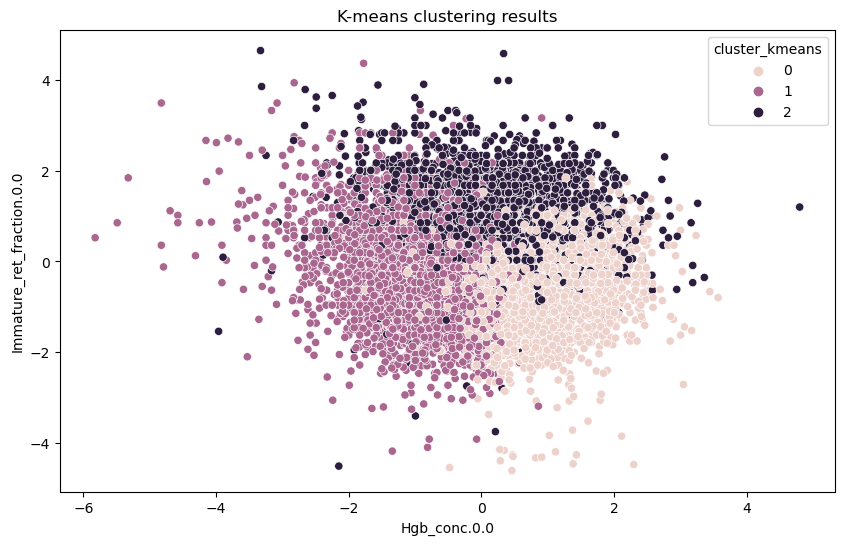

In [86]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

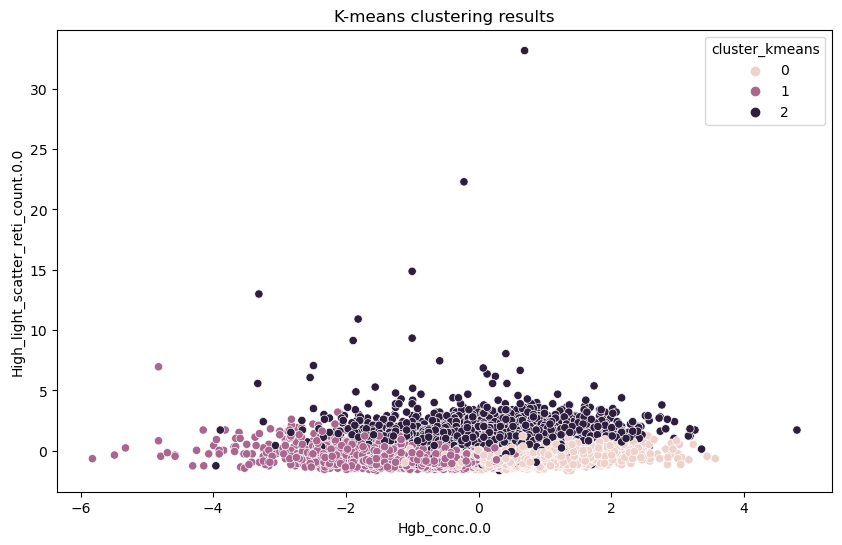

In [87]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Hgb_conc.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Hgb_conc.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

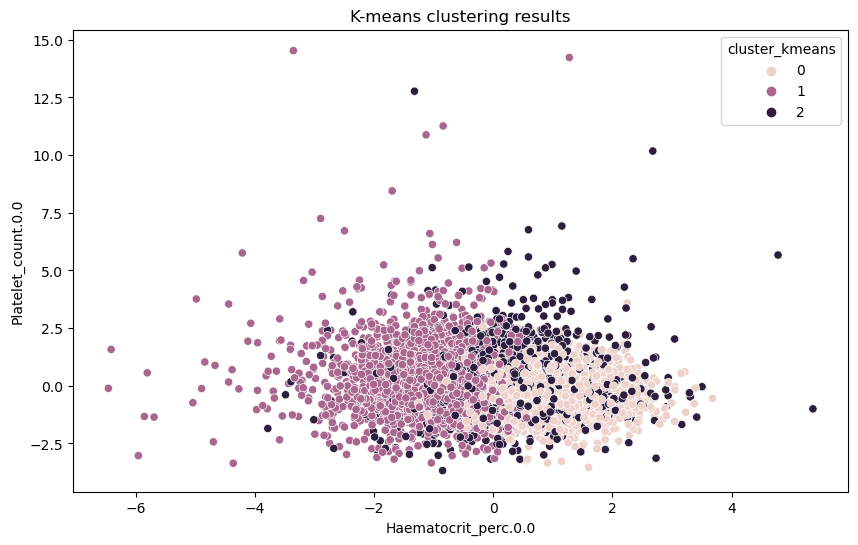

In [88]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Haematocrit_perc.0.0', y='Platelet_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Haematocrit_perc.0.0')
plt.ylabel('Platelet_count.0.0')
plt.show()

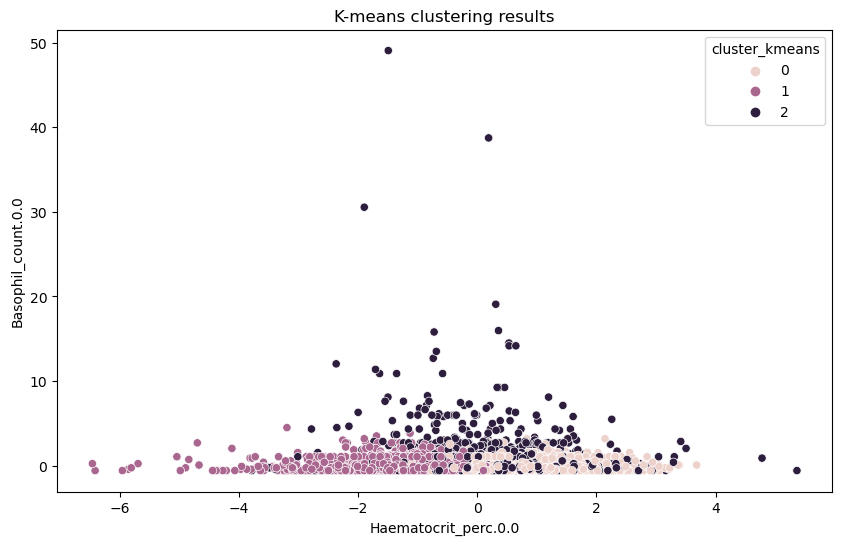

In [89]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Haematocrit_perc.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Haematocrit_perc.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

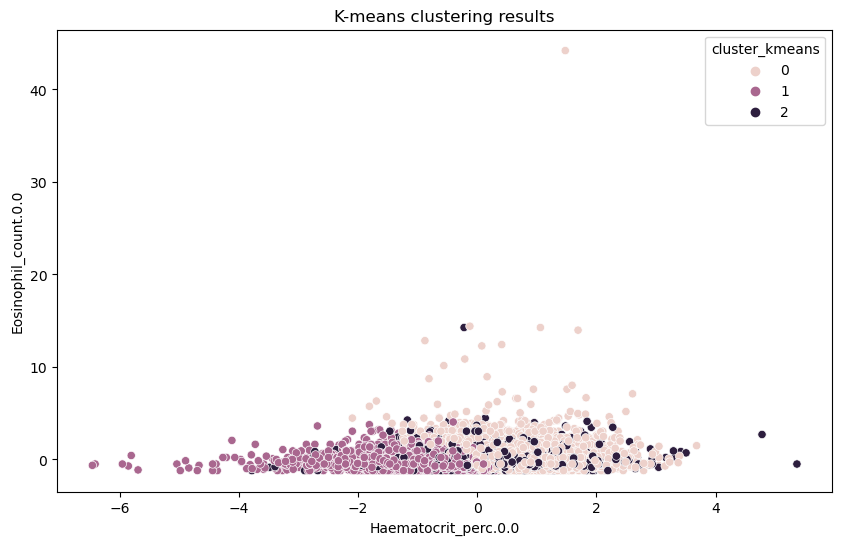

In [90]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Haematocrit_perc.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Haematocrit_perc.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

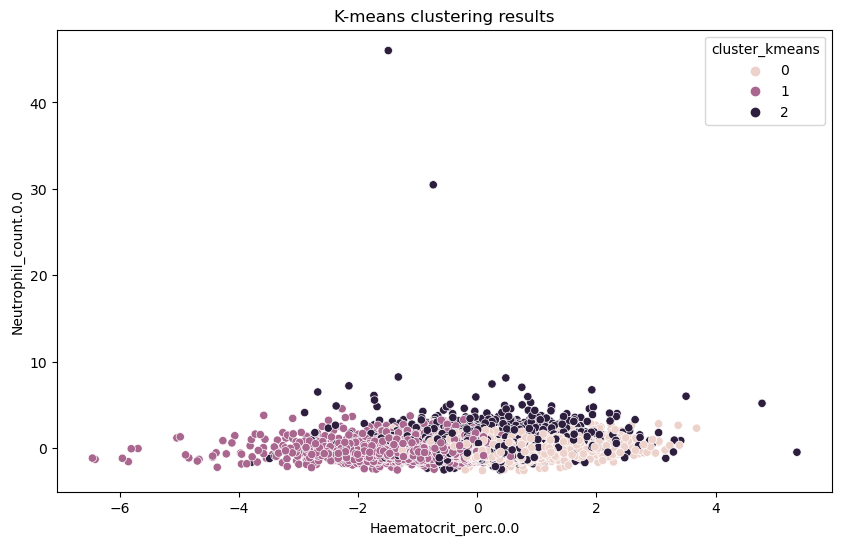

In [91]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Haematocrit_perc.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Haematocrit_perc.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

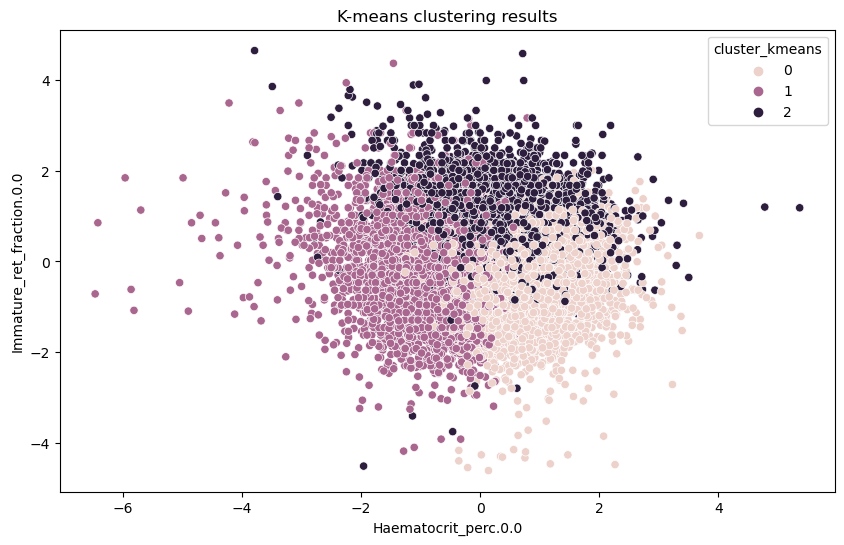

In [92]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Haematocrit_perc.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Haematocrit_perc.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

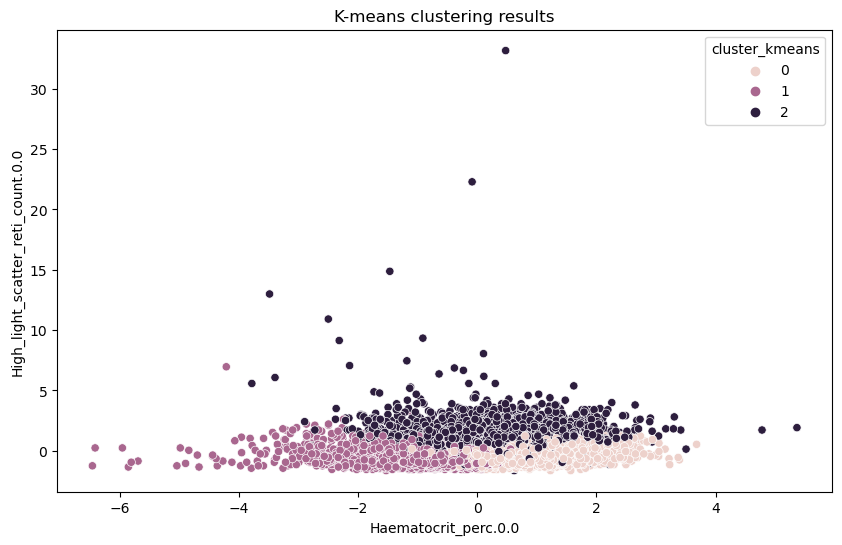

In [93]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Haematocrit_perc.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Haematocrit_perc.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

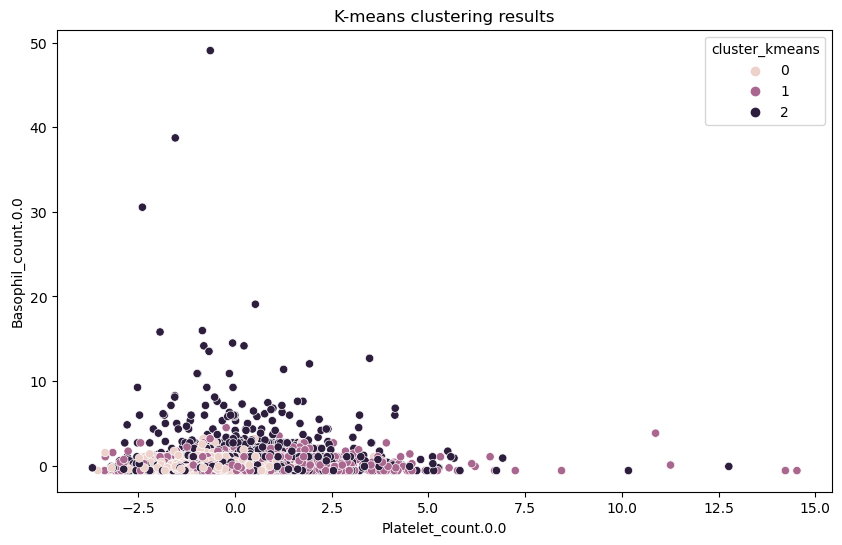

In [94]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Platelet_count.0.0', y='Basophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Platelet_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.show()

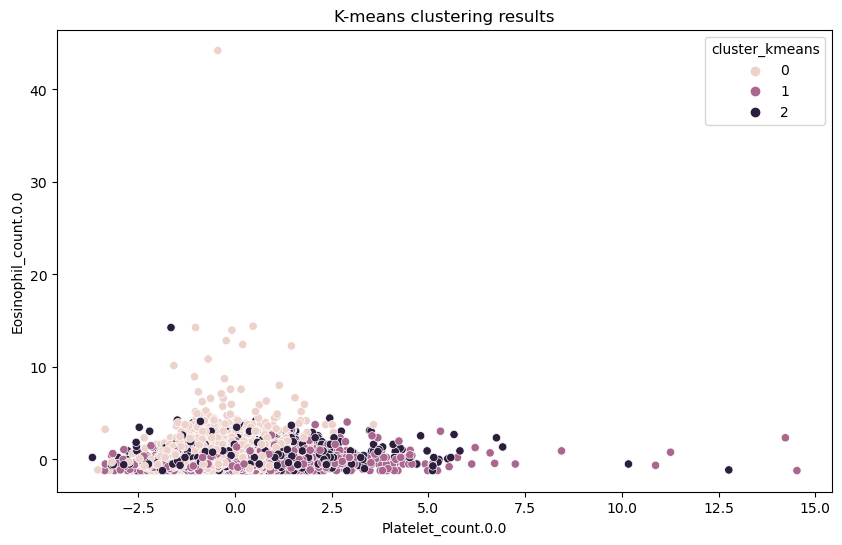

In [95]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Platelet_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Platelet_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

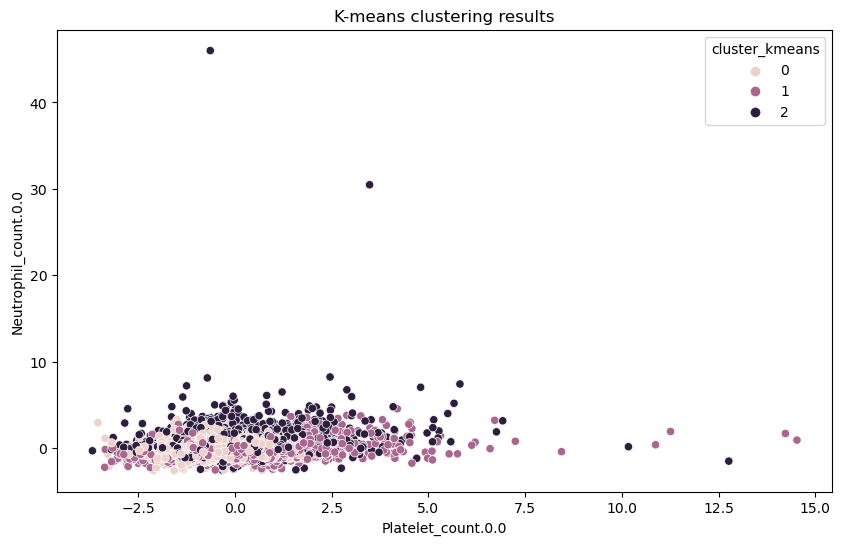

In [96]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Platelet_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Platelet_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

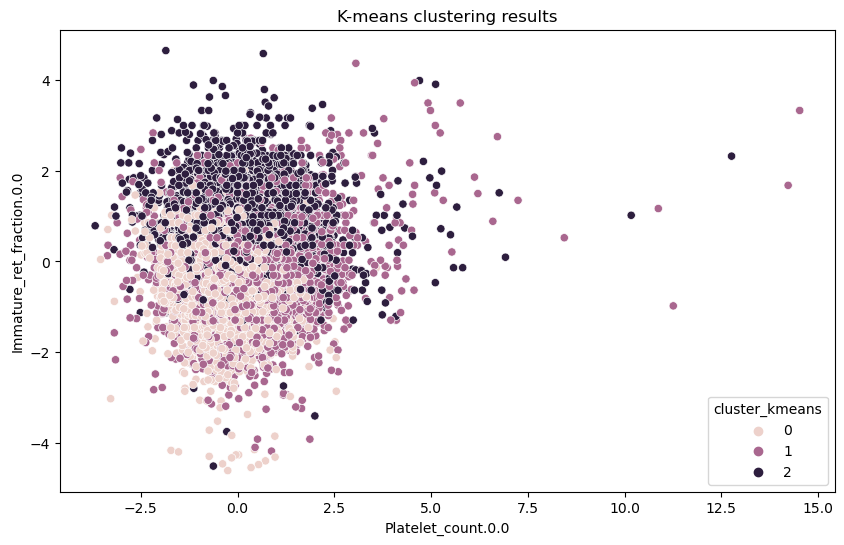

In [97]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Platelet_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Platelet_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

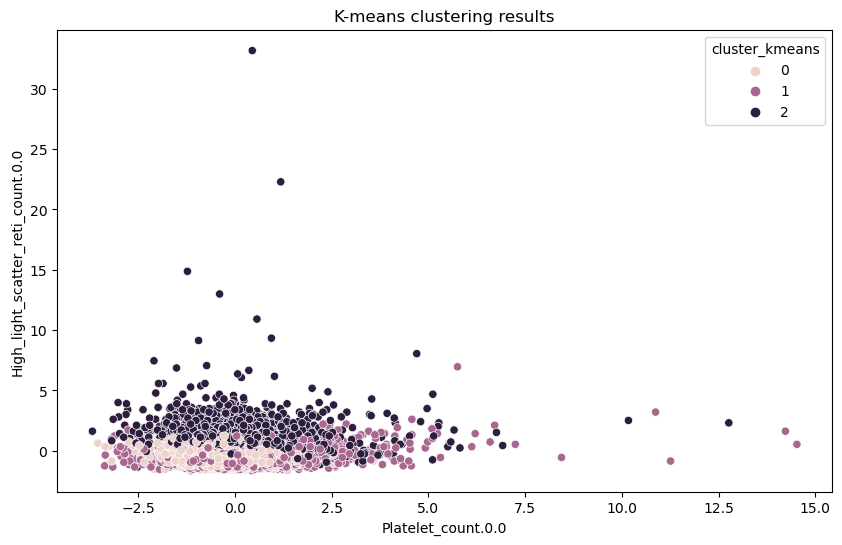

In [98]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Platelet_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Platelet_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

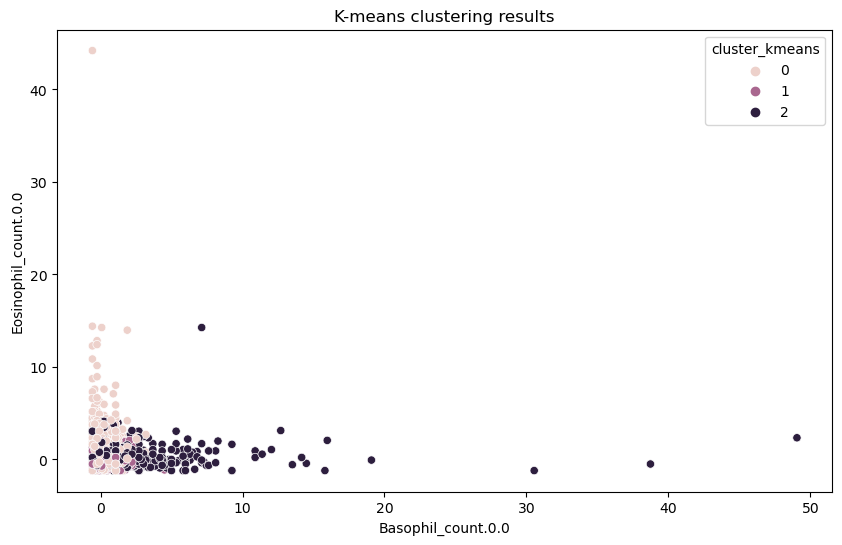

In [99]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Basophil_count.0.0', y='Eosinophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Basophil_count.0.0')
plt.ylabel('Eosinophil_count.0.0')
plt.show()

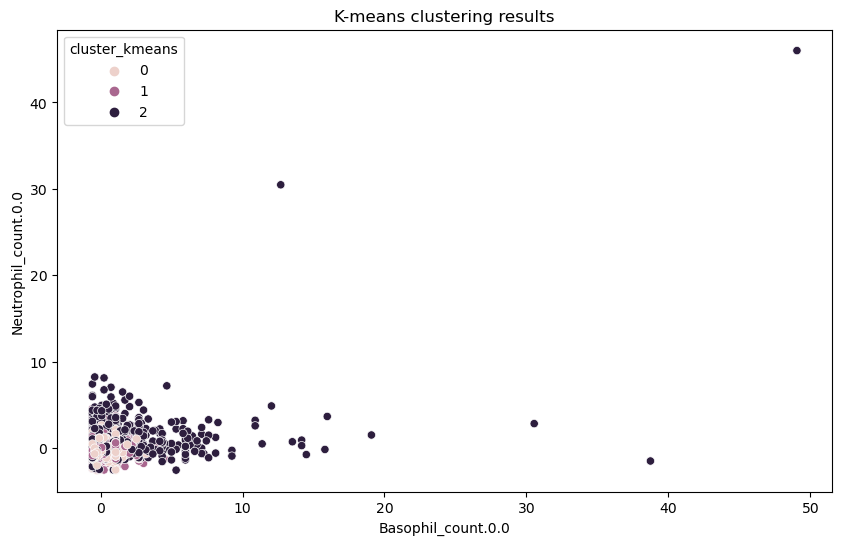

In [100]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Basophil_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Basophil_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

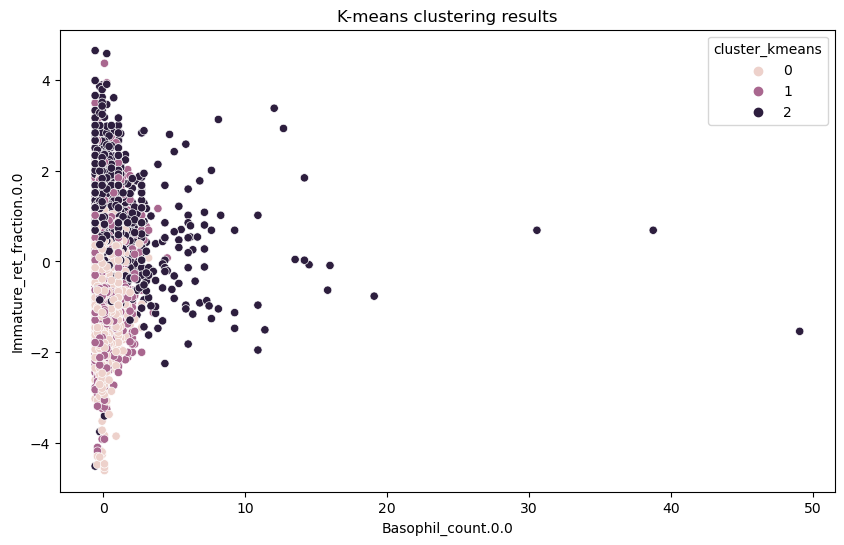

In [101]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Basophil_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Basophil_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

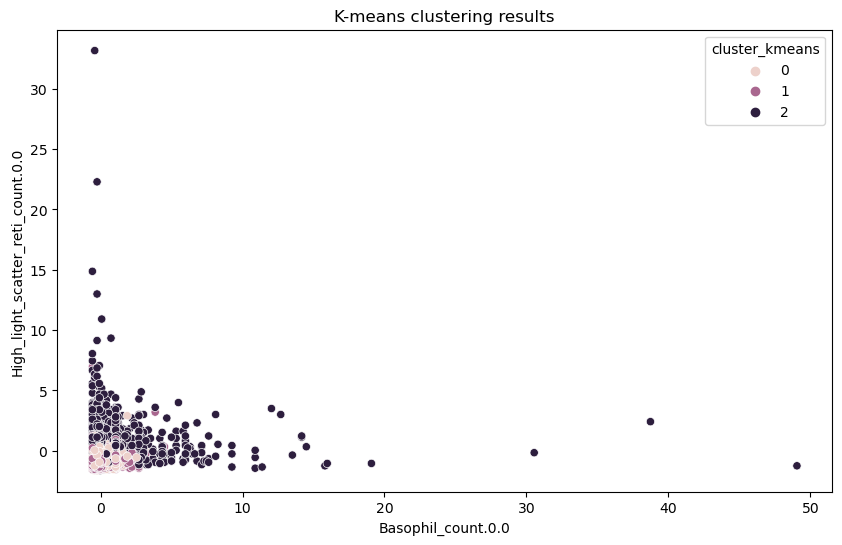

In [102]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Basophil_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Basophil_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

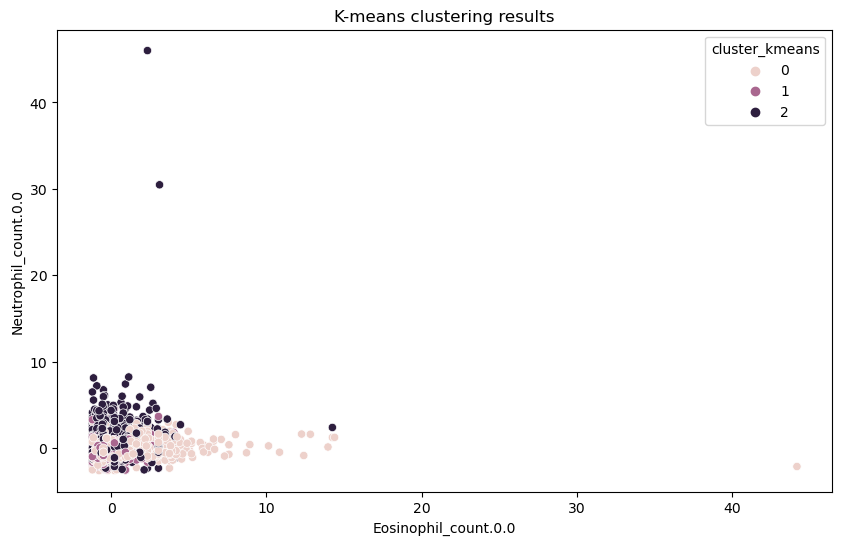

In [103]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Eosinophil_count.0.0', y='Neutrophil_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Eosinophil_count.0.0')
plt.ylabel('Neutrophil_count.0.0')
plt.show()

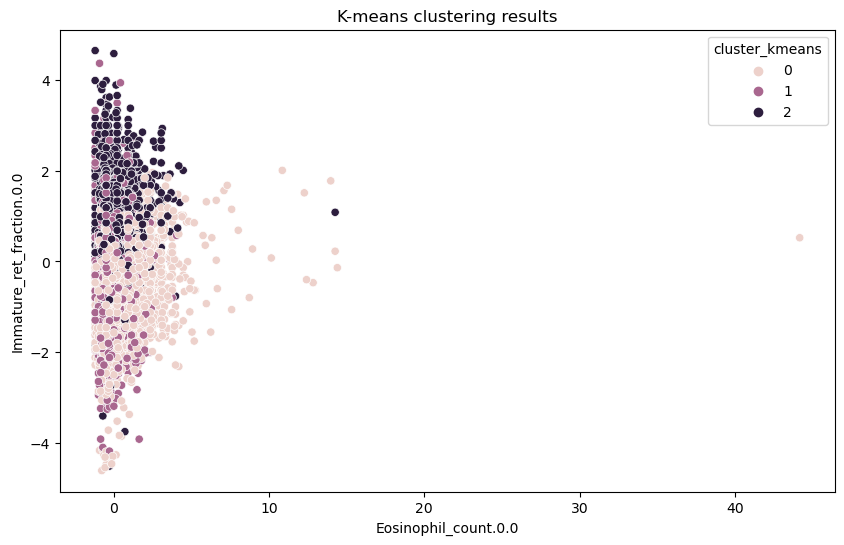

In [104]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Eosinophil_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Eosinophil_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

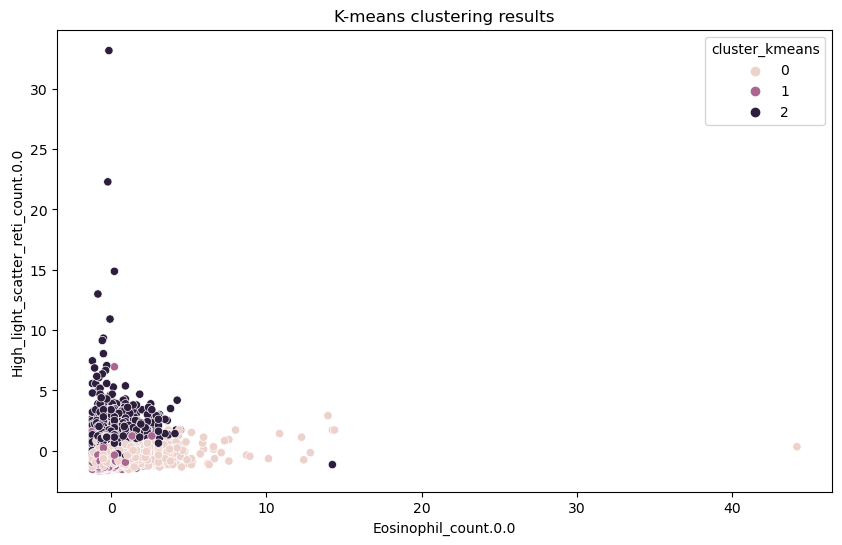

In [105]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Eosinophil_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Eosinophil_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

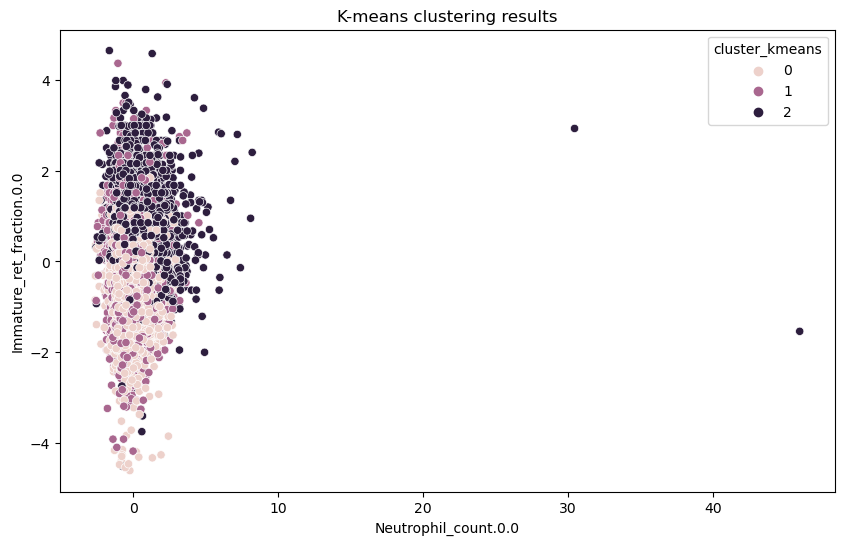

In [106]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Neutrophil_count.0.0', y='Immature_ret_fraction.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Neutrophil_count.0.0')
plt.ylabel('Immature_ret_fraction.0.0')
plt.show()

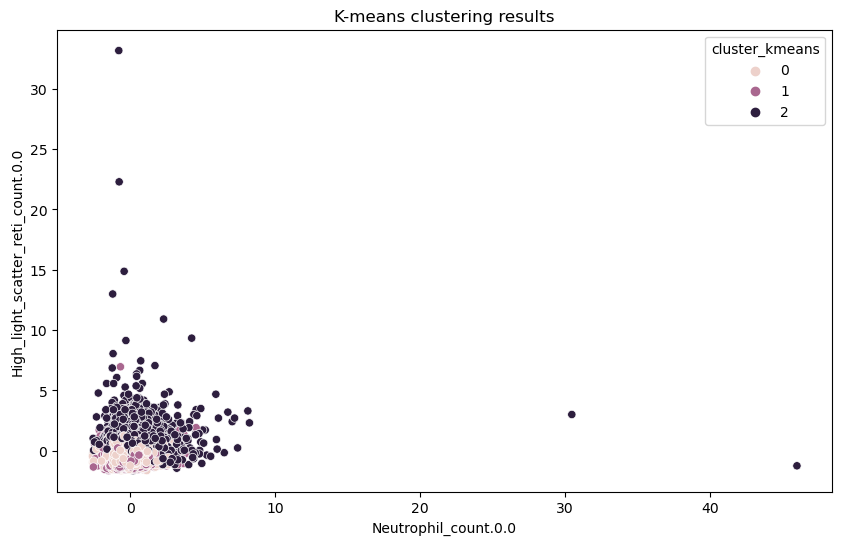

In [107]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Neutrophil_count.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Neutrophil_count.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

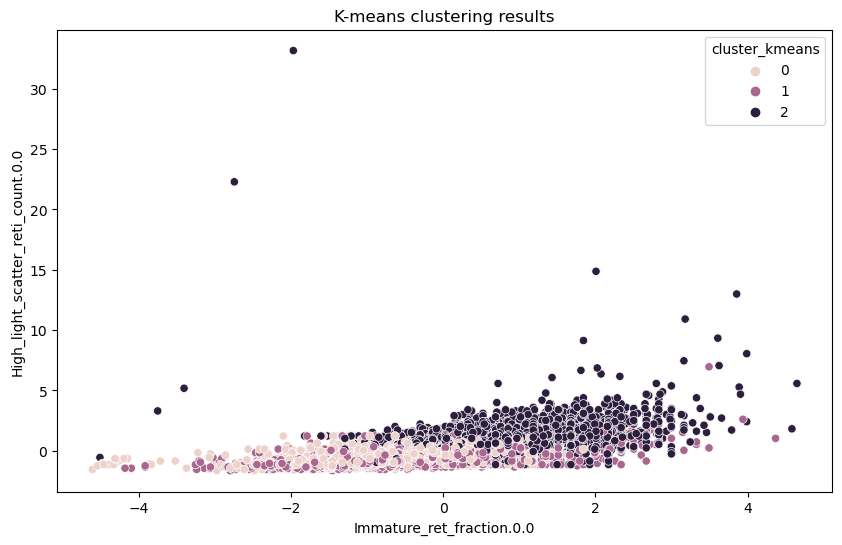

In [108]:
# Plot the data points with different colors for each cluster
sns.scatterplot(x='Immature_ret_fraction.0.0', y='High_light_scatter_reti_count.0.0', hue='cluster_kmeans', data=df_standardized)
plt.title('K-means clustering results')
plt.xlabel('Immature_ret_fraction.0.0')
plt.ylabel('High_light_scatter_reti_count.0.0')
plt.show()

The scatterplot with different colors for each cluster can provide valuable insights into the structure of the data and the quality of the clustering algorithm. Here are some possible interpretations:

1. Well-separated clusters: If the clusters are well-separated and distinct from each other, it suggests that the clustering algorithm has successfully identified meaningful groups within the data. In this case, the plot will show clearly separated clusters with minimal overlap between them.

2. Overlapping clusters: If the clusters overlap, it suggests that the clustering algorithm has identified some meaningful structure within the data, but there may be some ambiguity in the boundaries between the groups. In this case, the plot will show some overlap between the different clusters.

3. No clear clustering: If there is no clear clustering structure in the data, the plot will show a random scatter of points with no clear groupings.

4. Outliers: The plot may also reveal the presence of outliers or anomalous data points that do not fit well into any of the clusters.

Overall, the scatterplot can provide a quick visual assessment of the quality of the clustering algorithm and help you identify any potential issues or areas for further investigation.

I want to predict the cancer status, so I need to add the cancer column back into the df_standardized dataframe 

In [118]:
print(type(df_standardized))


<class 'pandas.core.frame.DataFrame'>


In [119]:
import pandas as pd

# Load the original data
df_original = pd.read_csv('/rds/general/user/hg1222/home/Group5/matching/matched_data.csv')

# Extract the cancer column from the original dataframe
cancer_col = df_original['cancer']

# Add the cancer column to the standardized dataframe
df_standardized['cancer'] = cancer_col

# Save the combined dataframe as a CSV file
df_combined = df_standardized.to_csv("df_combined.csv", index=False)


In [120]:
# Load the combined data
df_combined = pd.read_csv('/rds/general/user/hg1222/home/df_combined.csv')

In [121]:
print(df_combined)

       Lymphocyte_count.0.0  Monocyte_count.0.0  Reti_count.0.0  \
0                  0.101115            0.000724        0.380855   
1                  1.352502           -0.097026       -0.584809   
2                 -0.089314           -0.097026        0.187722   
3                  0.373155            0.098473        0.270493   
4                  1.298094            0.049599       -0.557218   
...                     ...                 ...             ...   
14620             -0.143722           -0.009051        0.518807   
14621              0.073910            0.196223       -0.308905   
14622             -0.143722            0.000724       -0.419266   
14623              0.335070           -0.292524       -0.612399   
14624             -0.143722           -0.194775       -0.308905   

       WBC_count.0.0  RBC_count.0.0  Hgb_conc.0.0  Haematocrit_perc.0.0  \
0           0.195336       0.901972     -0.088446              0.017708   
1           1.362884       0.381643     -0.58

In [122]:
import pandas as pd

# Create a cross-tabulation table of the cluster labels and PLS categories
table1 = pd.crosstab(df_standardized['cluster_kmeans'], df_PLS['cancer'])

# Add a row for the total number of samples in each cluster
table1.loc['Total'] = table1.sum(axis=0)

# Add a column for the total number of samples in each PLS category
table1['Total'] = table1.sum(axis=1)

# Display the table
print(table1)


NameError: name 'df_PLS' is not defined

df_PLS is a dataframe containing the PLS category column. It is being used in the pd.crosstab() function to create a cross-tabulation table with the cluster labels.



qs: then do I still need to 'cancer' to be add back to the standardized dataframe or not????

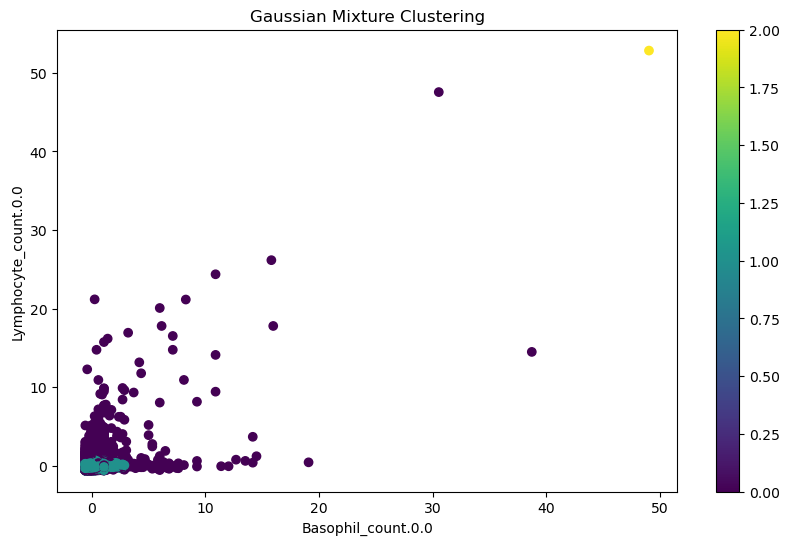

In [19]:
#### Gaussian Mixture 
import matplotlib.pyplot as plt

# Extract the two columns of interest for plotting
x = df_standardized['Basophil_count.0.0']
y = df_standardized['Lymphocyte_count.0.0']

# Plot the data points with colors according to their cluster labels
plt.scatter(x, y, c=cluster_labels, cmap='viridis')
plt.colorbar()

# Add plot title and axis labels
plt.title('Gaussian Mixture Clustering')
plt.xlabel('Basophil_count.0.0')
plt.ylabel('Lymphocyte_count.0.0')

# Show the plot
plt.show()


[   0  925 2160 ...  266  512 2293]
int64
[   0    1    2 ... 2954 2955 2956]
[ True False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


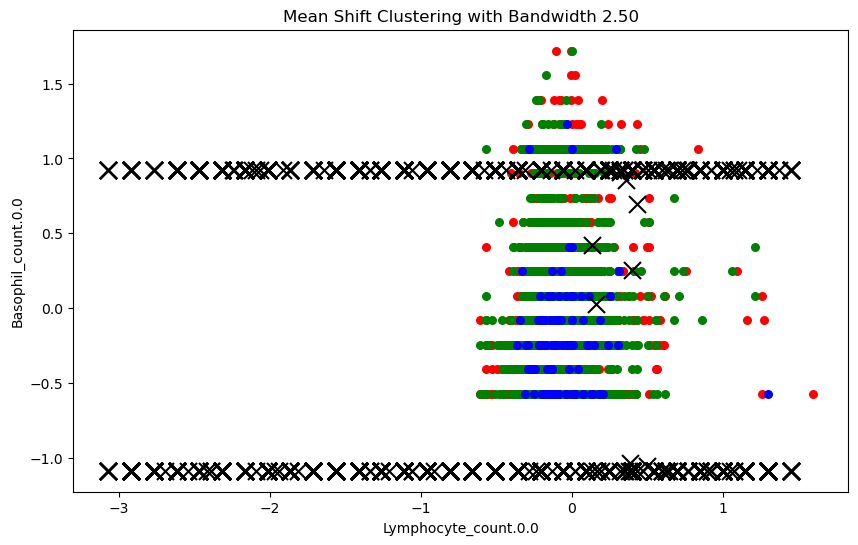

In [18]:

### mean shift 

import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Initialize bandwidth
bandwidth = 2.5

# Initialize MeanShift object with bandwidth parameter
ms = MeanShift(bandwidth=bandwidth)

# Fit the data
ms.fit(df_standardized)

# Get labels and cluster centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Print labels array for troubleshooting
print(labels)
print(labels.dtype)
print(np.unique(labels))

# Get number of clusters
n_clusters = 3

# Create a scatter plot with different colors for each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(n_clusters):
    # Print indexing expression for troubleshooting
    print(labels == i)
    plt.scatter(df_standardized.loc[labels == i, 'Lymphocyte_count.0.0'], df_standardized.loc[labels == i, 'Basophil_count.0.0'], color=colors[i%8], s=30)

# Plot the cluster centers as black crosses
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=150, marker='x', color='k')

# Add axis labels and title
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.title(f"Mean Shift Clustering with Bandwidth {bandwidth:.2f}")

# Show the plot
plt.show()

In [44]:
print(df_standardized)

       Age_recr.0.0   Sex.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
0         -0.206118  0.920864  0.816489        -0.595990           -0.744352   
1          0.998828  0.920864 -0.691057        -0.595990            0.718840   
2         -0.657972 -1.085936  0.426256        -0.595990           -0.744352   
3          0.998828 -1.085936  1.213872        -0.595990            0.718840   
4          1.300064  0.920864 -0.276291        -0.595990            0.718840   
...             ...       ...       ...              ...                 ...   
14620      0.697591  0.920864  1.291068        -0.595990           -0.744352   
14621      0.697591  0.920864 -1.394210         1.260924           -0.744352   
14622      1.300064  0.920864 -1.060986        -0.595990            0.718840   
14623      1.300064 -1.085936 -1.172738        -0.595990           -0.744352   
14624      0.697591  0.920864  0.433008         1.260924            2.182032   

       Alc_drinker_status.0.0  Lymphocy

In [15]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Evaluate K-Means clustering performance
kmeans_inertia = kmeans.inertia_
kmeans_silhouette = silhouette_score(df_standardized, kmeans.labels_)
kmeans_calinski = calinski_harabasz_score(df_standardized, kmeans.labels_)

# Evaluate Gaussian Mixture clustering performance
gmm_bic = gmm.bic(df_standardized)
gmm_silhouette = silhouette_score(df_standardized, gmm.predict(df_standardized))
gmm_calinski = calinski_harabasz_score(df_standardized, gmm.predict(df_standardized))

print("K-Means - Inertia: {}, Silhouette Score: {}, Calinski-Harabasz Index: {}".format(kmeans_inertia, kmeans_silhouette, kmeans_calinski))
print("Gaussian Mixture - BIC: {}, Silhouette Score: {}, Calinski-Harabasz Index: {}".format(gmm_bic, gmm_silhouette, gmm_calinski))


K-Means - Inertia: 9761029.0, Silhouette Score: 0.0797656504341567, Calinski-Harabasz Index: 710.7237137761366
Gaussian Mixture - BIC: 531466.6151279701, Silhouette Score: 0.21750567947707974, Calinski-Harabasz Index: 773.7456397336307


In [22]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score, calinski_harabasz_score

#Perform Mean Shift clustering

ms = MeanShift()
ms.fit(df_standardized)

#Evaluate Mean Shift clustering performance

ms_silhouette = silhouette_score(df_standardized, ms.labels_)
ms_calinski = calinski_harabasz_score(df_standardized, ms.labels_)

print("Mean Shift - Silhouette Score: {}, Calinski-Harabasz Index: {}".format(ms_silhouette, ms_calinski))

Mean Shift - Silhouette Score: 0.17145280801279703, Calinski-Harabasz Index: 50.12083910266089


It seems like Gaussian mixture is more suitable???

In [16]:
# Add the cluster labels as a new column
df_standardized['cluster_kmeans'] = kmeans.labels_

# Add the cluster labels to the dataframe
df_standardized['cluster_gaussian'] = cluster_labels

In [17]:
print(df_standardized)

       Age_recr.0.0   Sex.0.0   BMI.0.0  Mood_swings.0.0  Smoking_status.0.0  \
0         -0.206118  0.920864  0.816489        -0.595990           -0.744352   
1          0.998828  0.920864 -0.691057        -0.595990            0.718840   
2         -0.657972 -1.085936  0.426256        -0.595990           -0.744352   
3          0.998828 -1.085936  1.213872        -0.595990            0.718840   
4          1.300064  0.920864 -0.276291        -0.595990            0.718840   
...             ...       ...       ...              ...                 ...   
14620      0.697591  0.920864  1.291068        -0.595990           -0.744352   
14621      0.697591  0.920864 -1.394210         1.260924           -0.744352   
14622      1.300064  0.920864 -1.060986        -0.595990            0.718840   
14623      1.300064 -1.085936 -1.172738        -0.595990           -0.744352   
14624      0.697591  0.920864  0.433008         1.260924            2.182032   

       Alc_drinker_status.0.0  Lymphocy

[   0  606 2210 ...  282  531 2343]
int64
[   0    1    2 ... 3010 3011 3012]
[ True False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]


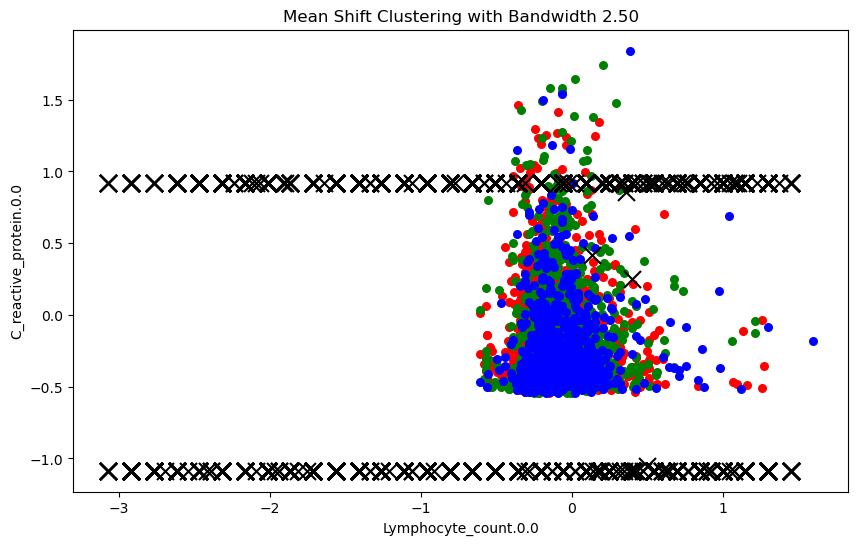

In [38]:
### mean shift 

import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
import matplotlib.pyplot as plt

# Initialize bandwidth
bandwidth = 2.5

# Initialize MeanShift object with bandwidth parameter
ms = MeanShift(bandwidth=bandwidth)

# Fit the data
ms.fit(df_standardized)

# Get labels and cluster centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Print labels array for troubleshooting
print(labels)
print(labels.dtype)
print(np.unique(labels))

# Get number of clusters
n_clusters = 3

# Create a scatter plot with different colors for each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(n_clusters):
    # Print indexing expression for troubleshooting
    print(labels == i)
    plt.scatter(df_standardized.loc[labels == i, 'Lymphocyte_count.0.0'], df_standardized.loc[labels == i, 'Basophil_count.0.0'], color=colors[i%8], s=30)

# Plot the cluster centers as black crosses
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=150, marker='x', color='k')

# Add axis labels and title
plt.xlabel('Lymphocyte_count.0.0')
plt.ylabel('Basophil_count.0.0')
plt.title(f"Mean Shift Clustering with Bandwidth {bandwidth:.2f}")

# Show the plot
plt.show()

Number of clusters: 0


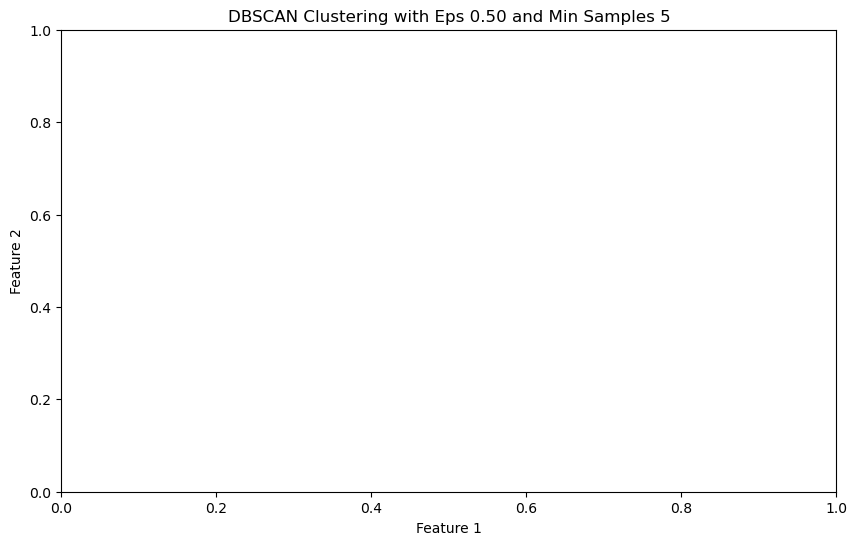

In [24]:
from sklearn.cluster import DBSCAN
import numpy as np

# Initialize DBSCAN object with eps and min_samples parameters
eps = 0.5
min_samples = 5
dbscan = DBSCAN(eps=eps, min_samples=min_samples)

# Fit the data
dbscan.fit(df_standardized)

# Get labels
labels = dbscan.labels_

# Get number of clusters (excluding noise points, labeled as -1)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {n_clusters}")

# Create a scatter plot with different colors for each cluster
colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k', 'w']
for i in range(n_clusters):
    # Print indexing expression for troubleshooting
    print(labels == i)
    plt.scatter(df_standardized[labels == i, 0], df_standardized[labels == i, 1], color=colors[i%8], s=30)

# Add axis labels and title
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title(f"DBSCAN Clustering with Eps {eps:.2f} and Min Samples {min_samples}")

# Show the plot
plt.show()
